In [2]:
pip install polars

Note: you may need to restart the kernel to use updated packages.


# Processing and expanding dictionary columns

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import polars as pl
from ydata_profiling import ProfileReport
import ast

In [3]:
df = pl.read_parquet('/kaggle/input/csc2025-quang-feature-removed/quang.parquet')

In [ ]:
keys_event = set()

for row in df['event_properties'].value_counts().sort('count', descending=True).iter_rows():
    keys_event = set(ast.literal_eval(row[0]).keys()).union(keys_event)

In [5]:
keys_user = set()

for row in df['user_properties'].value_counts().iter_rows():
    keys_user = set(ast.literal_eval(row[0]).keys()).union(keys_user)

In [6]:
len(keys_event), len(keys_user)

(71, 27)

In [7]:
keys_event = list(keys_event)
keys_user = list(keys_user)

In [8]:
print(df.shape)
df.head()

(2639235, 26)


$schema,amplitude_id,city,client_event_time,client_upload_time,country,data,device_brand,device_family,device_id,device_type,dma,event_id,event_properties,event_time,event_type,library,os_name,processed_time,region,server_received_time,server_upload_time,session_id,user_id,user_properties,__index_level_0__
str,i64,str,datetime[μs],datetime[μs],str,str,str,str,str,str,str,i64,str,datetime[μs],str,str,str,datetime[μs],str,datetime[μs],datetime[μs],i64,str,str,i64
"""None""",857540511408,"""Nashville""",2024-08-12 15:06:17.027,2024-08-12 15:06:19.182,"""United States""","""{'path': '/2/httpapi', 'group_…","""None""","""Windows""","""c3c73918-5e10-4a41-87dd-620d58…","""Windows""","""Nashville, TN""",10720,"""{'rowModel': 'legacyServer', '…",2024-08-12 15:06:17.027,"""dashboard:my-book:configurable…","""amplitude-ts/2.7.2""","""Chrome""",2024-08-12 15:06:20.098,"""Tennessee""",2024-08-12 15:06:19.182,2024-08-12 15:06:19.198,1723475177031,"""4d408c96-bf8a-4f87-8291-a7be79…","""{'initial_utm_medium': 'EMPTY'…",6857
"""None""",857543317405,"""Hoboken""",2024-09-12 08:51:48.193,2024-09-12 08:51:49.397,"""United States""","""{'path': '/2/httpapi', 'group_…","""None""","""Windows""","""2ad9e406-ba56-4bbf-870e-286a5c…","""Windows""","""New York, NY""",29983,"""{'displayName': 'Quota Share',…",2024-09-12 08:51:48.193,"""account-lines::widget:render""","""amplitude-ts/2.7.2""","""Edge""",2024-09-12 08:51:50.795,"""New Jersey""",2024-09-12 08:51:49.397,2024-09-12 08:51:49.399,1726122006359,"""3473675c-4986-4549-b988-ccb4ad…","""{'businessUnit': [], 'initial_…",78487
"""None""",857540480084,"""Nashville""",2023-12-12 11:07:22.001,2024-03-25 20:58:57.825,"""United States""","""{'path': '/batch', 'group_firs…","""None""","""Windows""","""6abedaa9-7db9-487e-a6ed-e7e359…","""Windows""","""Nashville, TN""",4,"""{}""",2023-12-12 11:07:22.001,"""dashboard:my-book:recent-actio…","""amplitude-ts/1.8.0""","""Edge""",2024-03-25 20:58:58.295,"""Tennessee""",2024-03-25 20:58:57.825,2024-03-25 20:58:57.830,1702379235836,"""9aecc15d-64a4-4190-80f5-b5b842…","""{'initial_utm_medium': 'EMPTY'…",19703
"""None""",857540490097,"""Aurora""",2024-12-19 14:12:20.442,2024-12-19 14:12:21.233,"""United States""","""{'path': '/2/httpapi', 'group_…","""None""","""Windows""","""f8fd578a-24b5-4108-8525-dd8edc…","""Windows""","""Denver, CO""",46320,"""{'rowModel': 'server', '[Ampli…",2024-12-19 14:12:20.442,""":all-accounts:configurable-tab…","""amplitude-ts/2.7.2""","""Chrome""",2024-12-19 14:12:22.180,"""Colorado""",2024-12-19 14:12:21.233,2024-12-19 14:12:21.235,1734617520136,"""e3e2850b-082a-4a5e-9ce5-c0c57e…","""{'initial_utm_medium': 'EMPTY'…",93754
"""None""",857540444317,"""Nashville""",2024-10-10 15:26:41.804,2024-10-10 15:26:42.870,"""United States""","""{'path': '/2/httpapi', 'group_…","""None""","""Windows""","""3630e88e-c688-4abc-b81d-11da1c…","""Windows""","""Nashville, TN""",9366,"""{'[Amplitude] Session Replay I…",2024-10-10 15:26:41.804,"""account-property-rating:perils…","""amplitude-ts/2.7.2""","""Chrome""",2024-10-10 15:26:43.531,"""Tennessee""",2024-10-10 15:26:42.870,2024-10-10 15:26:42.876,1728569532592,"""b5e87951-22bd-4333-9a0d-ae28ec…","""{'businessUnit': ['UA Queue'],…",15720


In [4]:
del df

In [8]:
def automate_enforce_types(df: pl.DataFrame) -> pl.DataFrame:
    for col in df.columns:
        try:
            df = df.with_columns(df[col].cast(pl.Float64))
            if df[col].drop_nulls().to_list() and all(float(x).is_integer() for x in df[col].drop_nulls().to_list()):
                df = df.with_columns(df[col].cast(pl.Int64))
        
        except Exception:
            try:
                df = df.with_columns(df[col].str.to_datetime(strict=False, format=None))
            
            except Exception as e:
                print(f"Skipping column {col} due to error: {e}")
    
    return df


def data_profile(df: pd.DataFrame, output_file: str = "data_profile.html"):
    profile = ProfileReport(df)
    profile.to_file(output_file)
    print(f'Data profile saved as: {output_file}')

# def safe_literal_eval(x):
#     print('HI')
#     try:
#         return ast.literal_eval(x)
#     except:
#         return {}

def safe_literal_eval(x, include_col):
    x = ast.literal_eval(x)
    for key in list(x.keys()):
        if key not in include_col:
            x.pop(key)
    ret = {}
    for key in include_col:
        ret[key] = x.get(key, None)
    return ret

def process_row(s):
    lst = s.values()
    return [str(x) for x in lst]

def expand_column_helper(df: pl.DataFrame, column: str, include_col, drop: bool = True):
    df = df.with_columns(
        pl.col(column).map_elements(lambda x: process_row(safe_literal_eval(x, include_col)), return_dtype=pl.List(pl.String)).alias(column + '_list'),
    )
    

    df = df\
        .with_row_index()\
        .explode(column + '_list')\
        .with_columns(on=pl.format(column + "_{}", pl.int_range(pl.len()).over("index") + 1))\
        .pivot(on="on", values=column + '_list')

    return df

def create_band(df: pl.DataFrame, band_dict: dict) -> pl.DataFrame:
    for col, itv in band_dict.items():
        df = df.with_columns(
            pl.col(col).map_elements(lambda x: itv[sum(x.total_seconds() >= (band / 1e6) for band in itv)-1] / 1e6, return_dtype=pl.Float64).alias(f"{col}_band_seconds")
        )

    return df


In [9]:
import os

def expand_column(df_path, output_path, column, shape, include_col):
    for idx in range(0, shape, 500000):
        df = pl.read_parquet(df_path)[[column]]
        df = expand_column_helper(df[idx:min(shape, idx + 500000)], column, include_col)
        df.write_parquet(f"df_{idx}.parquet")
    del df
    
    df_combined = None
    for file in os.listdir(output_path):
        if 'df' not in file:
            continue
    
        print(file)
        df_small = pl.read_parquet(output_path + file)
    
        if df_combined is None:
            df_combined = df_small
            expected_columns = df_small.columns
        else:
            missing_cols = set(expected_columns) - set(df_small.columns)
            extra_cols = set(df_small.columns) - set(expected_columns)
    
            for col in missing_cols:
                df_small = df_small.with_columns(pl.lit(float("nan")).alias(col))
                
            df_small = df_small.select(expected_columns)
            df_combined = pl.concat([df_combined, df_small], how="vertical_relaxed")
    
        del df_small
        
    df_combined.drop(['index', column]).write_parquet('train.parquet')

In [37]:
# expand_column('/kaggle/input/eda-dataset/quang.parquet', '/kaggle/working/', 'user_properties', 2639235, 
#               include_col = keys_user
# )

expand_column('/kaggle/input/eda-dataset/quang.parquet', '/kaggle/working/', 'event_properties', 2639235, 
              include_col = keys_event
)

df_1500000.parquet
df_2500000.parquet
df_1000000.parquet
df_0.parquet
df_2000000.parquet
df_500000.parquet


In [38]:
df_test = pl.read_parquet('/kaggle/working/train.parquet')

In [34]:
df_test = df_test.rename({f'user_properties_{i}': keys_user[i-1] for i in range(1, 28)})

In [40]:
df_test = df_test.rename({f'event_properties_{i}': keys_event[i-1] for i in range(1, 72)})

In [41]:
df_test.head()

internalEmailId,route,path,rowModel,element.props.customAccordion.title,option,element.key,groupId,accountId,[Amplitude] Page Title,rules,menuVisible,filename,[Amplitude] Page URL,hasAccounts,variant,isCustomAccordion,tableId,element.props.customAccordion.meta,element.props.customAccordion.isPublished,quoteName,element.props.customAccordion.id,[Amplitude] Page Domain,messageId,resourceComponent.featureKey,account-id,policy-id,status,slug,referrer,formId,account-type,policyId,attachmentId,element.props.customAccordion.css,error,address,tab,resourceComponent.name,udoc,menu,accountType,displayName,type,[Amplitude] Page Path,buttonType,element.props.customAccordion.tab,items,element.props.customAccordion.__typename,item,id,lineOfBusiness,line-of-business,resourceComponent.featureKeyName,element.props.customAccordion.accountType,element.props.customAccordion.category,[Amplitude] Page Counter,templateName,emailId,version,resourceComponent.ui.defaultVariant,element.props.customAccordion.js,action,name,hasAssignees,resourceComponent.category,referring_domain,element.props.name,[Amplitude] Session Replay ID,[Amplitude] Page Location,eventType
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""None""","""None""","""None""","""client""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""documents-and-compliance-table""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""da71a6d8-f04d-4b28-a996-0aef14…","""None""","""None"""
"""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""all-policies""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""All Policies""","""built-in""","""None""","""None""","""None""","""None""","""None""","""None""","""bf07f7e7-e02e-48d8-ac65-d3e124…","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""4d686f28-0d02-4e90-88d0-8c1a56…","""None""","""None"""
"""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""general""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""91e8d66a-b7d4-4a71-a288-16e6c8…","""None""","""None"""
"""None""","""None""","""None""","""server""","""None""","""None""",""

In [42]:
df_test.write_parquet('event_properties.parquet')

In [36]:
df_test.write_parquet('user_properties.parquet')

In [44]:
df_user = pl.read_parquet('/kaggle/working/user_properties.parquet')
df_event = pl.read_parquet('/kaggle/working/event_properties.parquet')
df = pl.read_parquet('/kaggle/input/eda-dataset/quang.parquet')

In [45]:
df_user = df_user.rename({'referrer': 'referrer_user', 'referring_domain':'referring_domain_user'})

In [46]:
df_final = pl.concat([df, df_event, df_user], how="horizontal")

In [47]:
df_final.write_parquet('quang.parquet')

In [28]:
del df_test, df_final

In [30]:
del df_user, df_event

In [24]:
df_final

$insert_id,$insert_key,$schema,adid,amplitude_attribution_ids,amplitude_event_type,amplitude_id,app,city,client_event_time,client_upload_time,country,data,data_type,device_brand,device_carrier,device_family,device_id,device_manufacturer,device_model,device_type,dma,event_id,event_properties,event_time,event_type,global_user_properties,group_properties,groups,idfa,is_attribution_event,language,library,location_lat,location_lng,os_name,os_version,…,initial_utm_medium,initial_referring_domain,initial_utm_content,roles,isInternalUser,initial_utm_campaign,trackingVersion,initial_twclid,referrer,initial_gclid,hostname,initial_utm_source,initial_dclid,initial_wbraid,initial_fbclid,initial_utm_id,initial_referrer,initial_gbraid,initial_utm_term,initial_msclkid,initial_ttclid,initial_ko_click_id,referring_domain,element.props.customAccordion.tab,groupId,element.props.customAccordion.js,element.props.customAccordion.__typename,element.props.customAccordion.title,element.props.customAccordion.category,isCustomAccordion,element.props.customAccordion.isPublished,element.props.customAccordion.meta,element.props.customAccordion.accountType,element.props.customAccordion.id,element.props.customAccordion.css,name,id
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""4393489c-7f73-4ff4-ab62-ee3b87…","""None""","""None""","""None""","""None""","""None""","""857540435842""","""591532""","""Mumbai""","""2024-11-27 16:14:17.970000""","""2024-11-27 16:14:18.255000""","""India""","""{'path': '/2/httpapi', 'group_…","""event""","""None""","""None""","""Windows""","""2f74197d-a0cd-4ba1-920d-7f6864…","""None""","""None""","""Windows""","""None""","""45001""","""{'line-of-business': 'general-…","""2024-11-27 16:14:17.970000""","""account-lines:::view""","""None""","""{}""","""{}""","""None""","""None""","""English""","""amplitude-ts/2.7.2""","""None""","""None""","""Chrome""","""131""",…,"""EMPTY""","""EMPTY""","""customer_tozrg.federato.ai""","""EMPTY""","""EMPTY""","""EMPTY""","""None""","""EMPTY""","""False""","""EMPTY""","""['underwriter']""","""EMPTY""","""EMPTY""","""EMPTY""","""EMPTY""","""None""","""3.1""","""EMPTY""","""EMPTY""","""EMPTY""","""EMPTY""","""EMPTY""","""EMPTY""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None"""
"""59285604-d249-4aee-b3fc-39e2a9…","""None""","""None""","""None""","""None""","""None""","""857540546956""","""591532""","""Mumbai""","""2024-03-15 10:31:29.146000""","""2024-03-28 15:05:37.982000""","""India""","""{'path': '/batch', 'group_firs…","""event""","""None""","""None""","""Windows""","""59d6580f-0e9e-42cb-9274-96d212…","""None""","""None""","""Windows""","""None""","""176""","""{}""","""2024-03-15 10:31:29.146000""",""":all-accounts::view""","""None""","""{}""","""{}""","""None""","""None""","""English""","""amplitude-ts/1.8.0""","""None""","""None""","""Chrome""","""122.0.0.0""",…,"""EMPTY""","""EMPTY""","""customer_tozrg.federato.ai""","""EMPTY""","""EMPTY""","""EMPTY""","""EMPTY""","""EMPTY""","""False""","""EMPTY""","""['underwriter']""","""EMPTY""","""EMPTY""","""EMPTY""","""EMPTY""","""EMPTY""","""2.21""","""EMPTY""","""EMPTY""","""EMPTY""","""EMPTY""","""EMPTY""","""EMPTY""","""None""","""None""","""None""","""None""","""81af3ecd-d046-4445-ac75-94aaad…","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None""","""None"""
"""4a6c0857-ba3f-45c2-ba2a-0ada19…","""None""","""None""","""None""","""None""","""None""","""857540665429""","""591532""","""Nashville""","""2023-10-25 13:40:32.420000""","""2024-03-24 19:56:13.111000""","""United States""","""{'path': '/batch', 'group_firs…","""event""","""None""","""None""","""Windows""","""bd

# 

# feature engineering

In [ ]:
df = pl.read_parquet('/kaggle/input/eda-dataset/quang.parquet')

In [ ]:
# def process_row(x):
#     x = [int(element) for element in x]
#     return [x[:idx] for idx in range(1, len(x)+1)]

# def get_rnn_dataset(counts_limit, df):
#     event_to_idx = {}
#     idx_to_event = {}
#     event_types = df['event_type'].value_counts()['event_type'].to_pandas().values
#     for idx in range(len(event_types)):
#         event_to_idx[event_types[idx]] = idx
#         idx_to_event[idx] = event_types[idx]
        
#     df = df.with_columns([
#         pl.col('event_type').replace_strict(event_to_idx, default=None).alias('event_type_mapped')
#     ])
    
#     result = (
#     df.sort('event_time')
#       .group_by(['user_id', 'session_id'])
#       .agg([
#           pl.concat_str('event_type_mapped', separator=", ").alias('event_type_mapped'),
#           pl.count('event_type').alias('counts')
#       ]).filter(pl.col('counts') < counts_limit).with_columns(
#         pl.col('event_type_mapped').map_elements(
#             lambda x: process_row(x), return_dtype=pl.List(pl.List(pl.Int64))
#         ).alias('event_type_mapped' + '_list'),
#     ).explode('event_type_mapped' + '_list')
#     ).with_columns(
#         pl.col('event_type_mapped_list').map_elements(lambda x: x[-1], return_dtype=pl.Int64).alias('target'),
#         pl.col('event_type_mapped_list').map_elements(lambda x: x[:-1], return_dtype=pl.List(pl.Int64)).alias('event_type_mapped_list')
#     ).filter(
#         pl.col('event_type_mapped_list') != []
#     )
#     return result[['user_id', 'session_id', 'event_type_mapped_list', 'target']], event_to_idx, idx_to_event
# (result, event_to_idx, idx_to_event) = get_rnn_dataset(20, df)
# result.write_parquet('sample.parquet')
# result.head()

In [ ]:
# df = automate_enforce_types(df)
# df.write_parquet('quang.parquet')

In [ ]:
# columns_to_drop = [
#     "$insert_id", "$insert_key", "adid", "amplitude_attribution_ids", "amplitude_event_type",
#     "app", "data_type", "device_carrier", "device_brand", "device_manufacturer",
#     "device_model", "global_user_properties", "group_properties", "groups", "idfa",
#     "is_attribution_event", "language", "location_lat", "location_lng", "os_version",
#     "partner_id", "paying", "plan", "platform", "sample_rate", "source_id",
#     "start_version", "user_creation_time", "uuid", "version_name", "data", "$schema",
#     "internalEmailId", "route", "path", "rowModel", "option", "element.key", "groupId",
#     "accountId", "[Amplitude] Page Title", "rules", "menuVisible", "filename",
#     "[Amplitude] Page URL", "hasAccounts", "variant", "isCustomAccordion", "tableId",
#     "quoteName", "[Amplitude] Page Domain", "messageId", "resourceComponent.featureKey",
#     "policy-id", "status", "referrer", "formId", "account-type", "policyId",
#     "attachmentId", "error", "address", "tab", "resourceComponent.name", "udoc",
#     "menu", "accountType", "type", "[Amplitude] Page Path", "buttonType", "items",
#     "item", "id", "lineOfBusiness", "line-of-business", "[Amplitude] Page Counter",
#     "templateName", "emailId", "version", "action", "name", "hasAssignees",
#     "resourceComponent.category", "referring_domain", "element.props.name",
#     "[Amplitude] Page Location", "eventType", "initial_wbraid", "initial_utm_source",
#     "initial_msclkid", "initial_utm_campaign", "initial_referring_domain",
#     "initial_utm_id", "initial_li_fat_id", "bazinga", "initial_ko_click_id",
#     "initial_fbclid", "initial_gclid", "initial_rtd_cid", "initial_utm_term",
#     "initial_dclid", "initial_gbraid", "initial_referrer", "initial_utm_medium",
#     "initial_utm_content", "initial_twclid", "initial_ttclid", 'element.props.customAccordion.title',
#  'element.props.customAccordion.meta', 'element.props.customAccordion.isPublished', 'element.props.customAccordion.id', 
#     'element.props.customAccordion.css', 'element.props.customAccordion.tab',
#  'element.props.customAccordion.__typename', 'element.props.customAccordion.accountType',
#  'element.props.customAccordion.category', 'resourceComponent.ui.defaultVariant', 'element.props.customAccordion.js',
#      'resourceComponent.featureKeyName', 'account-id', 
# ]

# Based on user_session
columns_to_drop = ['$insert_key',
 '$schema',
 'adid',
 'amplitude_attribution_ids',
 'amplitude_event_type',
 'device_brand',
 'device_carrier',
 'device_manufacturer',
 'device_model',
 'global_user_properties',
 'idfa',
 'is_attribution_event',
 'location_lat',
 'location_lng',
 'partner_id',
 'paying',
 'sample_rate',
 'source_id',
 'start_version',
 'user_creation_time',
 'version_name',
 'internalEmailId',
 'route',
 'path',
 'element.props.customAccordion.title',
 'option',
 'element.key',
 'groupId',
 'accountId',
 '[Amplitude] Page Title',
 'rules',
 'menuVisible',
 'filename',
 '[Amplitude] Page URL',
 'hasAccounts',
 'variant',
 'isCustomAccordion',
 'tableId',
 'element.props.customAccordion.meta',
 'element.props.customAccordion.isPublished',
 'quoteName',
 'element.props.customAccordion.id',
 '[Amplitude] Page Domain',
 'messageId',
 'resourceComponent.featureKey',
 'account-id',
 'policy-id',
 'status',
 'referrer',
 'formId',
 'account-type',
 'policyId',
 'attachmentId',
 'element.props.customAccordion.css',
 'error',
 'address',
 'tab',
 'resourceComponent.name',
 'udoc',
 'menu',
 'accountType',
 '[Amplitude] Page Path',
 'buttonType',
 'element.props.customAccordion.tab',
 'items',
 'element.props.customAccordion.__typename',
 'item',
 'lineOfBusiness',
 'line-of-business',
 'resourceComponent.featureKeyName',
 'element.props.customAccordion.accountType',
 'element.props.customAccordion.category',
 '[Amplitude] Page Counter',
 'templateName',
 'emailId',
 'resourceComponent.ui.defaultVariant',
 'element.props.customAccordion.js',
 'action',
 'name',
 'hasAssignees',
 'resourceComponent.category',
 'referring_domain',
 'element.props.name',
 '[Amplitude] Page Location',
 'eventType',
 'bazinga',
'data_type', 'data', 'device_type', 'os_version', 'group_properties', 'groups',
'plan', 'platform', 'uuid', '__index_level_0__', 'id', 'version', 'trackingVersion', 'initial_wbraid', 'initial_utm_source',
'initial_msclkid', 'initial_utm_campaign', 'initial_referring_domain', 'initial_utm_id', 'initial_li_fat_id',
'initial_ko_click_id', 'initial_fbclid', 'initial_gclid', 'initial_rtd_cid',
'initial_utm_term',	'initial_dclid',	'initial_gbraid',	'initial_referrer',	'initial_utm_medium', 'referring_domain_user',
'initial_utm_content', 'initial_twclid', 'initial_ttclid'
]


df = df.drop(columns_to_drop)

In [ ]:
columns_to_drop_joey_notebook = ['$insert_id', 'amplitude_id', 'app', 'city', 
                   'device_id', 'event_id', 'event_properties', 
                   'language', 'os_name', 'session_id', 'user_id', 
                   'user_properties', 'rowModel', 'type', 
                   '[Amplitude] Session Replay ID']

df = df.drop(columns_to_drop_joey_notebook)

In [ ]:
# for col in df.columns:
#     try:
#         temp = df[col].value_counts().filter((pl.col(col)=='None') | (pl.col(col)=='EMPTY'))
#         if df.shape[0] > 0:
#             print(temp)
#     except:
#         continue

In [ ]:
df.filter(pl.col("client_upload_time") == pl.col("server_received_time")).shape[0]

In [ ]:
df.shape[0]

In [ ]:
df[['client_event_time', 'client_upload_time', 'processed_time', 'server_received_time', 'server_upload_time']]

In [ ]:
df = df.with_columns(
    (pl.col('client_upload_time') - pl.col('client_event_time')).alias('time_to_server')
)
df = df.with_columns(
    (pl.col('server_upload_time') - pl.col('server_received_time')).alias('server_to_process')
)
df = df.with_columns(
    (pl.col('processed_time') - pl.col('server_upload_time')).alias('processing_time')
)

In [ ]:
# temp = df.group_by(['user_id', 'session_id']).agg(
#     pl.col('roles').n_unique().alias('counts')
# ).filter(pl.col('counts') > 1)
# temp

In [ ]:
df['rowModel'].value_counts()

In [ ]:
df

In [ ]:
df.filter(pl.col('device_family') != pl.col('device_type'))

In [ ]:
df.head()

In [ ]:
band_dict = {
    'time_to_sever': [0.0, 0.1 * 1e6 , 0.5 * 1e6, 0.1 * 1e7, 0.1 * 1e8, 0.1 * 1e9, 1 * 1e10, 1 * 1e11, 1 * 1e12, 1 * 1e13, 1 * 1e14]
}

In [ ]:
agg_exprs = [
    pl.min("client_event_time").alias("min_client_event_time"),
    pl.max("client_event_time").alias("max_client_event_time")
] + [pl.concat_str(col, separator=", ").alias(col) for col in df.columns if df[col].dtype == pl.String and col not in ]

user_session = df.group_by(['user_id', 'session_id']).agg(*agg_exprs)

In [ ]:
user_session.head()

In [39]:
df.sort(["user_id","session_id", "event_time"]).group_by(["user_id","session_id"]).agg(
    (pl.col("event_time").diff().mean()).alias("avg_time_between_events")
)

user_id,session_id,avg_time_between_events
str,i64,duration[μs]
"""777875fc-c47c-4b64-985c-5fe344…",1708112398288,3m 27s 311800µs
"""2120d1ca-5e56-4585-98a1-93a5d3…",1715169273810,8m 37s 191200µs
"""97ef6826-391f-4bdb-9ec0-cedd69…",1695745233188,32m 7s 163ms
"""0c4896b7-08fa-4cb4-852f-27ad58…",1737692557450,null
"""b892e771-d9f2-4238-96d0-7538fd…",1689184495666,null
…,…,…
"""01708ccf-437b-44ed-b5a0-2fed8f…",1736439729928,3m 9s 725313µs
"""9db51d4a-73a3-4a62-be43-508373…",1727940337882,4s 180250µs
"""a2b02628-c422-4398-9e8b-8c3e24…",1736084713415,794ms


In [22]:
band_dict_user_session = {
    'session_time': [0.0, 0.1 * 1e7, 0.1 * 1e8, 0.1 * 1e9, 1 * 1e10, 1 * 1e11, 1 * 1e15]
}
user_session = create_band(user_session, band_dict_user_session) 

In [23]:
user_session.null_count()

user_id,session_id,min_client_event_time,max_client_event_time,session_time,session_time_band_seconds
u32,u32,u32,u32,u32,u32
0,0,0,0,0,0


In [24]:
user_session['session_time_band_seconds'].value_counts().sort(by='session_time_band_seconds')

session_time_band_seconds,count
f64,u32
0.0,149372
1.0,24321
10.0,41864
100.0,141222
10000.0,4787
100000.0,5


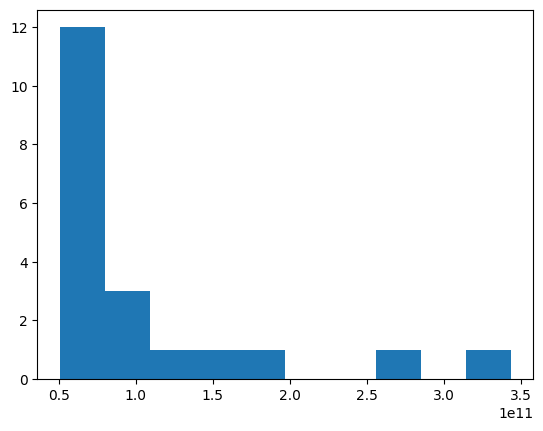

In [208]:
import matplotlib.pyplot as plt
plt.hist(user_session.filter(pl.col('session_time') > 0.5 * 1e11)['session_time'].to_physical())
plt.show()

# EDA against target after aggregating

In [55]:
df = pd.read_parquet('/kaggle/input/eda-dataset/preprocessed_data.parquet')

In [56]:
df.shape

(554760, 32)

In [57]:
df.isna().sum()

session_id                                        0
user_id_first                                     0
device_family_linux_max                           0
device_family_mac os x_max                        0
device_family_windows_max                         0
region_grouped_international_max                  0
region_grouped_midwest_max                        0
region_grouped_northeast_max                      0
region_grouped_south_max                          0
region_grouped_west_max                           0
event_category_account & policy management_max    0
event_category_action center & workflow_max       0
event_category_dashboard & ui interactions_max    0
event_category_other/system events_max            0
event_category_session & navigation_max           0
event_category_submission & forms_max             0
returned_within_28_days_max                       0
uw_max                                            0
admin_max                                         0
manager_max 

In [58]:
df.columns

Index(['session_id', 'user_id_first', 'device_family_linux_max',
       'device_family_mac os x_max', 'device_family_windows_max',
       'region_grouped_international_max', 'region_grouped_midwest_max',
       'region_grouped_northeast_max', 'region_grouped_south_max',
       'region_grouped_west_max',
       'event_category_account & policy management_max',
       'event_category_action center & workflow_max',
       'event_category_dashboard & ui interactions_max',
       'event_category_other/system events_max',
       'event_category_session & navigation_max',
       'event_category_submission & forms_max', 'returned_within_28_days_max',
       'uw_max', 'admin_max', 'manager_max', 'broker_max', 'google_max',
       'microsoft_max', 'session_seconds_mean', 'client_event_hour_mean',
       'client_upload_hour_mean', 'event_hour_mean',
       'server_received_hour_mean', 'server_upload_hour_mean',
       'time_to_server_mean', 'server_to_process_mean',
       'processing_time_mean']

In [59]:
def calculate_feature_correlation(df: pd.DataFrame, method: str = 'pearson') -> pd.DataFrame:
    """
    Calculates the correlation between each numerical feature in a DataFrame, excluding categorical columns.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame containing numerical and categorical features.
        method (str): Correlation method ('pearson', 'spearman', 'kendall'). Default is 'pearson'.
    
    Returns:
        pd.DataFrame: Correlation matrix.
    """
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")
    
    numeric_df = df.select_dtypes(include=['number'])
    return numeric_df.corr(method=method)

def find_high_correlation_features(corr_matrix: pd.DataFrame, threshold: float = 0.7) -> pd.DataFrame:
    """
    Find feature pairs with a correlation greater than the specified threshold.
    
    Parameters:
        corr_matrix (pd.DataFrame): Correlation matrix.
        threshold (float): The minimum correlation value to filter by.
    
    Returns:
        pd.DataFrame: Feature pairs with correlations greater than the threshold.
    """
    # Mask the correlation matrix to exclude values where the correlation is below the threshold or the same feature
    mask = (corr_matrix.abs() > threshold) & (corr_matrix != 1.0)
    high_corr_pairs = corr_matrix[mask].stack().reset_index()
    high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
    
    return high_corr_pairs

# Example usage
corr_matrix = calculate_feature_correlation(df)
high_corr_features = find_high_correlation_features(corr_matrix, threshold=0.7)
print(high_corr_features)

                   Feature 1                  Feature 2  Correlation
0                 session_id        time_to_server_mean    -0.770372
1    client_upload_hour_mean    server_upload_hour_mean     1.000000
2  server_received_hour_mean    server_upload_hour_mean     1.000000
3    server_upload_hour_mean    client_upload_hour_mean     1.000000
4    server_upload_hour_mean  server_received_hour_mean     1.000000
5        time_to_server_mean                 session_id    -0.770372


In [60]:
df.head()

,session_id,user_id_first,device_family_linux_max,device_family_mac os x_max,device_family_windows_max,region_grouped_international_max,region_grouped_midwest_max,region_grouped_northeast_max,region_grouped_south_max,region_grouped_west_max,...,microsoft_max,session_seconds_mean,client_event_hour_mean,client_upload_hour_mean,event_hour_mean,server_received_hour_mean,server_upload_hour_mean,time_to_server_mean,server_to_process_mean,processing_time_mean
0,1726807647035,b7256964-59d0-4873-a2c0-71fadf5524be,0,0,1,0,0,0,1,0,...,0,563.0,4.0,4.368421,4.0,4.368421,4.368421,1.179263e+03,0.0,2.157895
1,1719248323839,c15c83ab-a1be-44b4-8abb-3ef8bb449841,0,0,1,0,1,0,0,0,...,0,0.0,16.0,16.000000,16.0,16.000000,16.000000,2.000000e+00,0.0,1.000000
2,1736787964582,c15c83ab-a1be-44b4-8abb-3ef8bb449841,0,0,1,0,1,0,0,0,...,0,0.0,17.0,17.000000,17.0,17.000000,17.000000,3.000000e+00,0.0,1.000000
3,1697456042965,cd10dd53-64fe-4f2a-a640-63c812e9d0ac,0,0,1,0,0,0,1,0,...,0,299.0,11.0,17.000000,11.0,17.000000,17.000000,1.376039e+07,0.0,0.461538
4,1711973727499,f9347de9-4f2d-4a0a-9331-6dd06fa997d6,0,0,1,1,0,0,0,0,...,0,1805.0,12.0,21.000000,12.0,21.000000,21.000000,1.933817e+06,0.0,1.000000


In [67]:
df.columns

Index(['session_id', 'user_id_first', 'device_family_linux_max',
       'device_family_mac os x_max', 'device_family_windows_max',
       'region_grouped_international_max', 'region_grouped_midwest_max',
       'region_grouped_northeast_max', 'region_grouped_south_max',
       'region_grouped_west_max',
       'event_category_account & policy management_max',
       'event_category_action center & workflow_max',
       'event_category_dashboard & ui interactions_max',
       'event_category_other/system events_max',
       'event_category_session & navigation_max',
       'event_category_submission & forms_max', 'returned_within_28_days_max',
       'uw_max', 'admin_max', 'manager_max', 'broker_max', 'google_max',
       'microsoft_max', 'session_seconds_mean', 'client_event_hour_mean',
       'client_upload_hour_mean', 'event_hour_mean',
       'server_received_hour_mean', 'server_upload_hour_mean',
       'time_to_server_mean', 'server_to_process_mean',
       'processing_time_mean']

In [63]:
df = df.dropna(subset=['returned_within_28_days_max'])

In [21]:
df['uw_max' + '/' + 'manager_max'] = df['uw_max'] * df['manager_max']
df['uw_max' + '/' + 'admin_max'] = df['uw_max'] * df['admin_max']
df['uw_max' + '/' + 'broker_max'] = df['uw_max'] * df['broker_max']
df['uw_max' + '/' + 'manager_max' + 'admin_max'] = df['uw_max'] * df['manager_max']* df['admin_max']

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

def plot_categorical_vs_target(df, cat_col, target_col):
    """
    Plots a bar chart of the categorical column values with the target variable as a line chart on a secondary axis.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    cat_col (str): The categorical column to group by.
    target_col (str): The target variable to plot as a line chart.
    """
    # Calculate counts and mean target for each category
    data = df.groupby(cat_col, observed=False)[target_col].agg(['count', 'mean']).reset_index()
    data.sort_values(cat_col, inplace=True)
    print(data)
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Bar plot for counts
    sns.barplot(x=cat_col, y='count', data=data, ax=ax1, color='skyblue', alpha=0.7)
    ax1.set_xlabel(cat_col)
    ax1.set_ylabel('Count', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Line plot for mean target on secondary y-axis
    ax2 = ax1.twinx()
    sns.lineplot(x=cat_col, y='mean', data=data, ax=ax2, color='red', marker='o')
    ax2.set_ylabel(f'Mean {target_col}', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title(f'{cat_col} vs {target_col}')
    plt.show()

In [53]:
def plot_hist_vs_target(df, num_col, target_col, bins=10):
    """
    Plots a histogram of the numerical column with the target variable as a line chart on a secondary axis,
    after removing extreme values using the IQR method.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    num_col (str): The numerical column to create a histogram for.
    target_col (str): The target variable to plot as a line chart.
    bins (int): Number of bins for the histogram.
    """
    # Remove extreme values using the IQR method
    Q1 = df[num_col].quantile(0.25)
    Q3 = df[num_col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter the DataFrame
    df_filtered = df[(df[num_col] >= lower_bound) & (df[num_col] <= upper_bound)]
    
    # Bin the numerical column
    df_filtered['bin'] = pd.cut(df_filtered[num_col], bins=bins)
    
    # Calculate counts and mean target for each bin
    data = df_filtered.groupby('bin')[target_col].agg(['count', 'mean']).reset_index()

    # Sort by bin (convert to ordered category first)
    data['bin'] = pd.Categorical(data['bin'], ordered=True, categories=sorted(df_filtered['bin'].unique()))
    data.sort_values('bin', inplace=True)
    
    # Convert bin labels to strings for plotting
    data['bin'] = data['bin'].astype(str)

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Bar plot for counts (Histogram)
    sns.barplot(x='bin', y='count', data=data, ax=ax1, color='skyblue', alpha=0.7)
    ax1.set_xlabel(num_col)
    ax1.set_ylabel('Count', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

    # Line plot for mean target on secondary y-axis
    ax2 = ax1.twinx()
    sns.lineplot(x='bin', y='mean', data=data, ax=ax2, color='red', marker='o')
    ax2.set_ylabel(f'Mean {target_col}', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title(f'{num_col} Histogram vs {target_col} (Without Outliers)')
    plt.show()

device_family_linux_max
   device_family_linux_max   count      mean
0                        0  506240  0.065469
1                        1   48520  0.000062


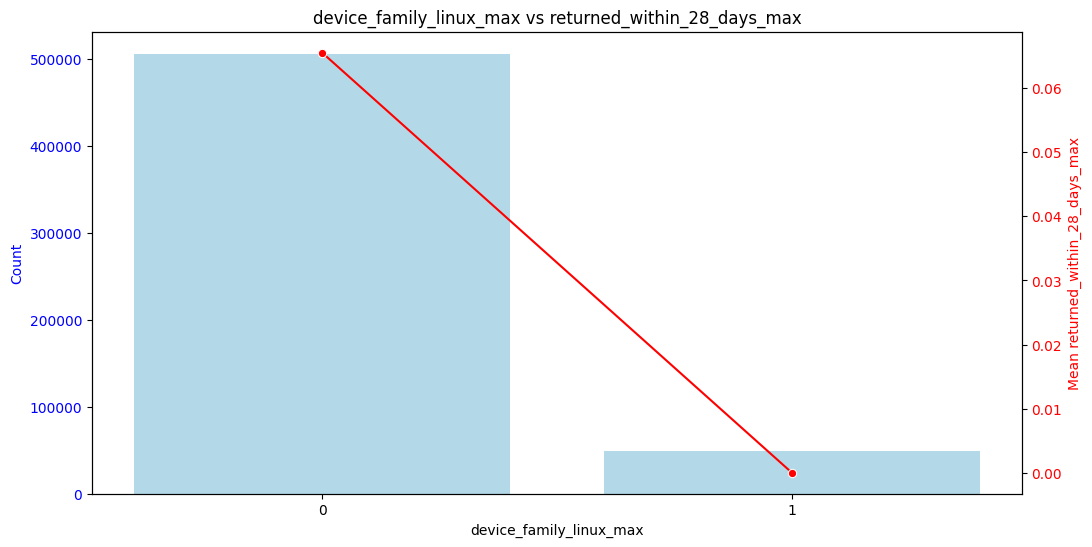

device_family_mac os x_max
   device_family_mac os x_max   count      mean
0                           0  504603  0.058355
1                           1   50157  0.073768


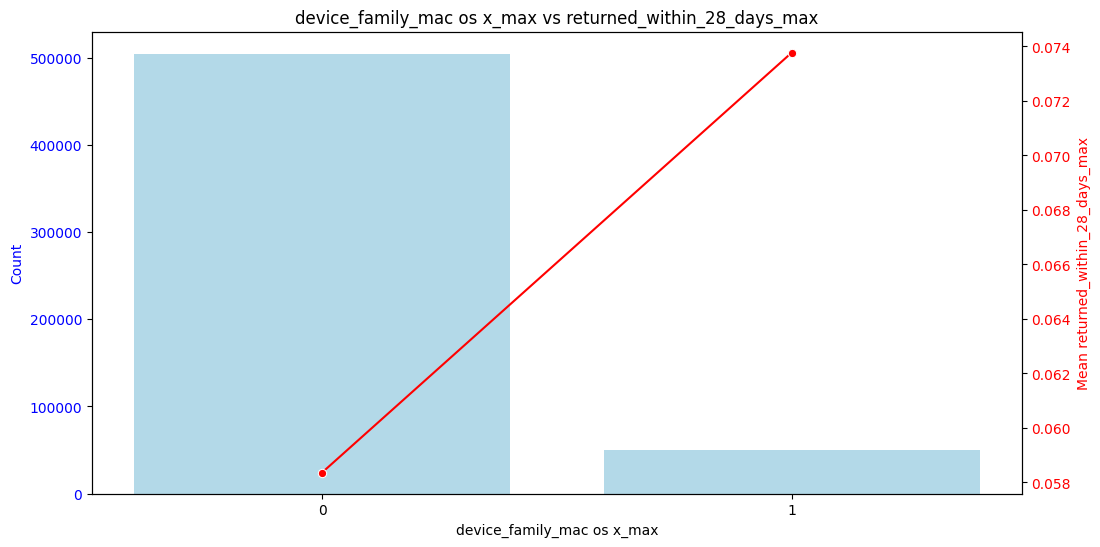

device_family_windows_max
   device_family_windows_max   count      mean
0                          0  120819  0.053377
1                          1  433941  0.061522


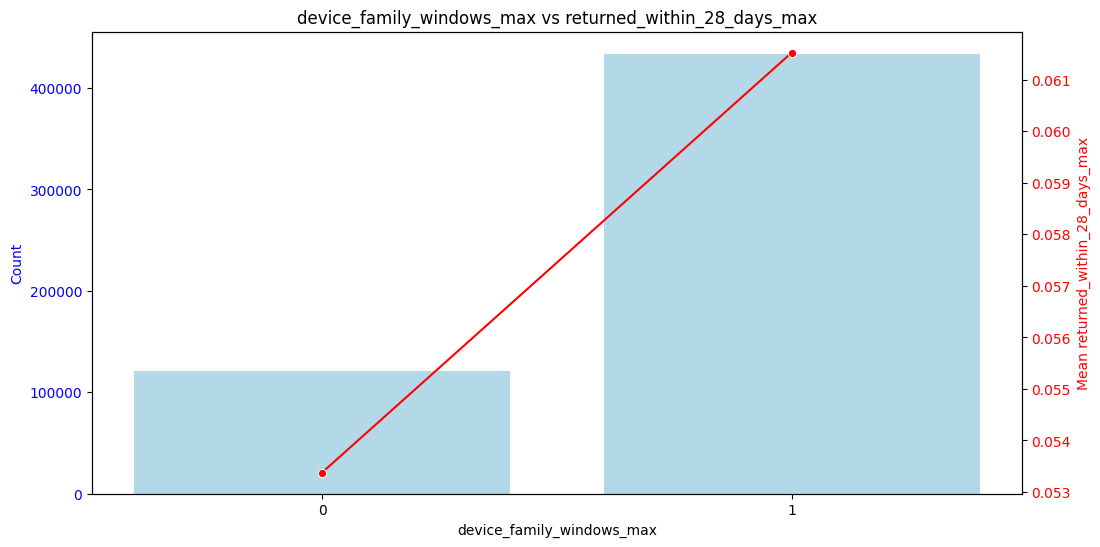

region_grouped_international_max
   region_grouped_international_max   count      mean
0                                 0  485073  0.062308
1                                 1   69687  0.041930


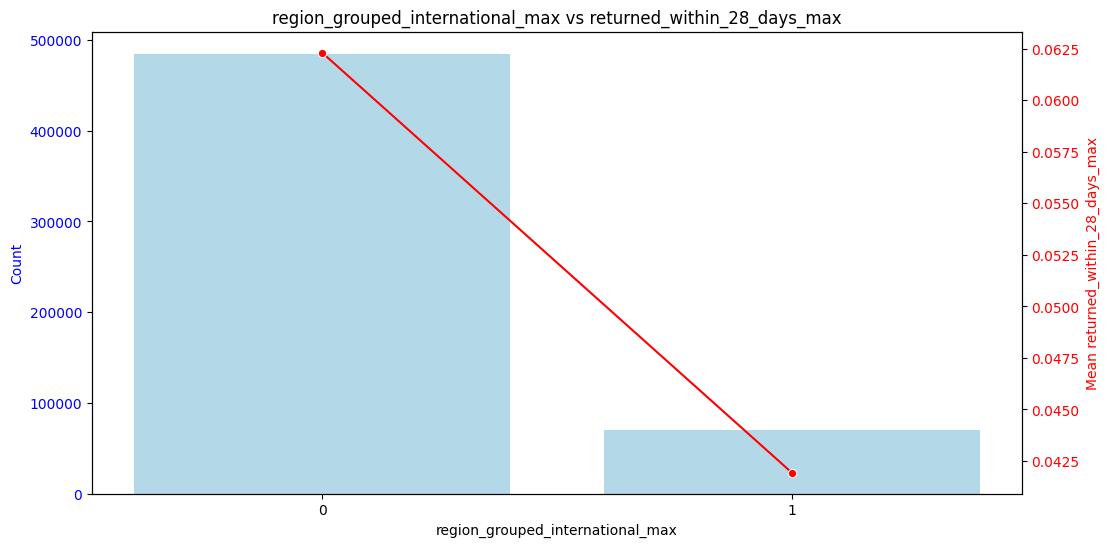

region_grouped_midwest_max
   region_grouped_midwest_max   count      mean
0                           0  464581  0.056113
1                           1   90179  0.078477


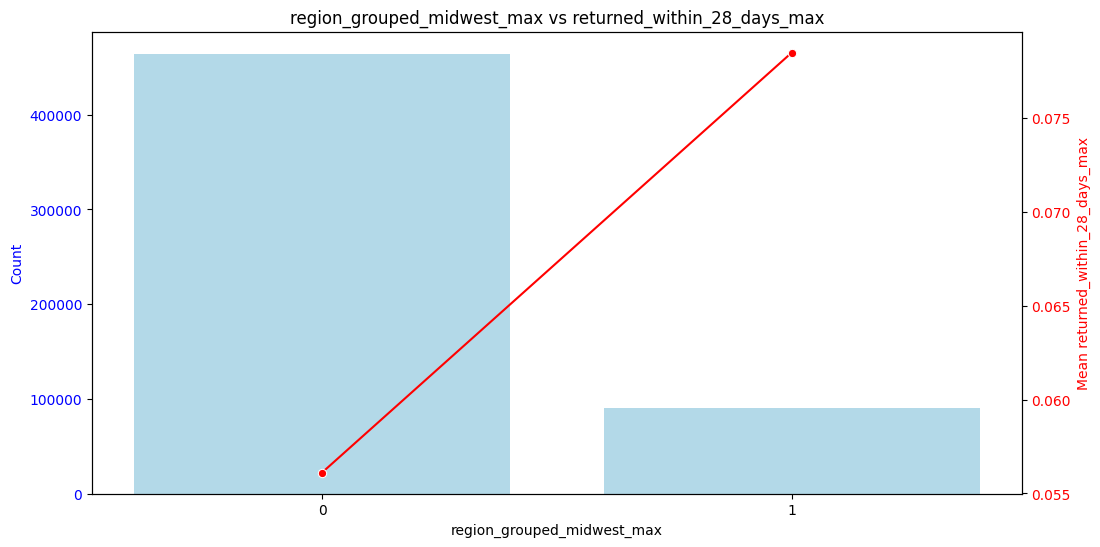

region_grouped_northeast_max
   region_grouped_northeast_max   count      mean
0                             0  519655  0.055102
1                             1   35105  0.128529


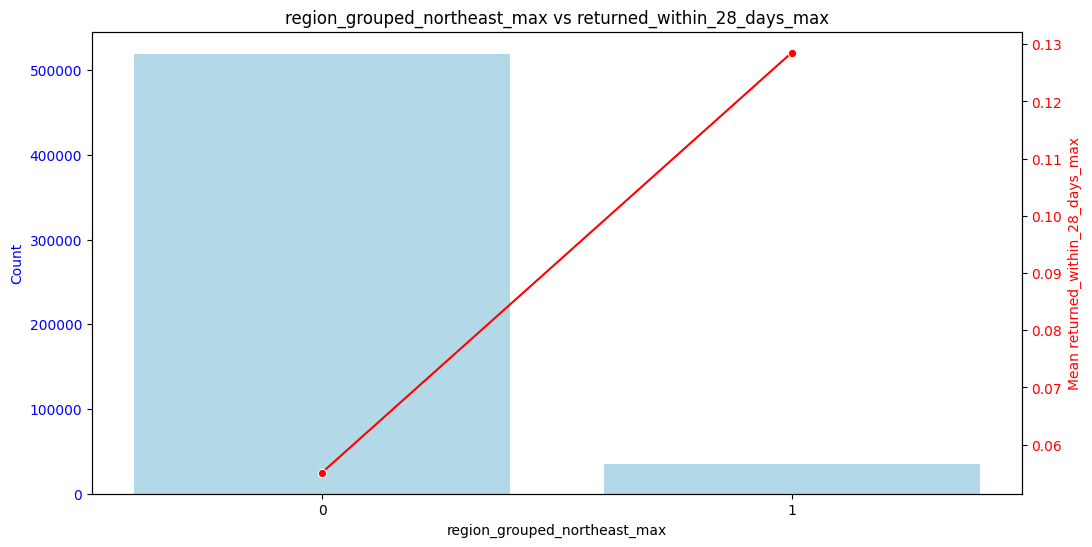

region_grouped_south_max
   region_grouped_south_max   count      mean
0                         0  247214  0.072213
1                         1  307546  0.049729


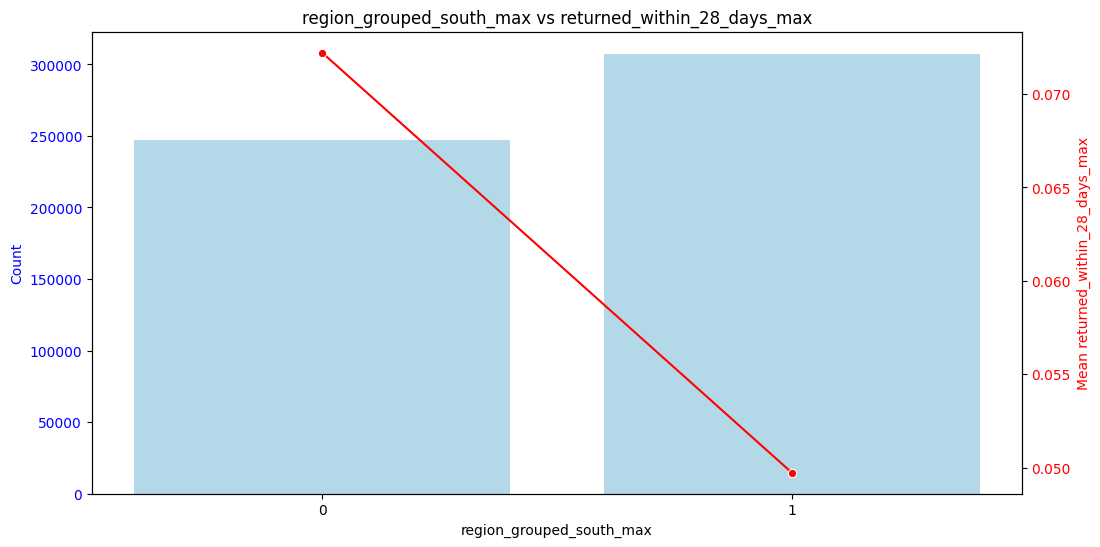

region_grouped_west_max
   region_grouped_west_max   count      mean
0                        0  500073  0.058465
1                        1   54687  0.071480


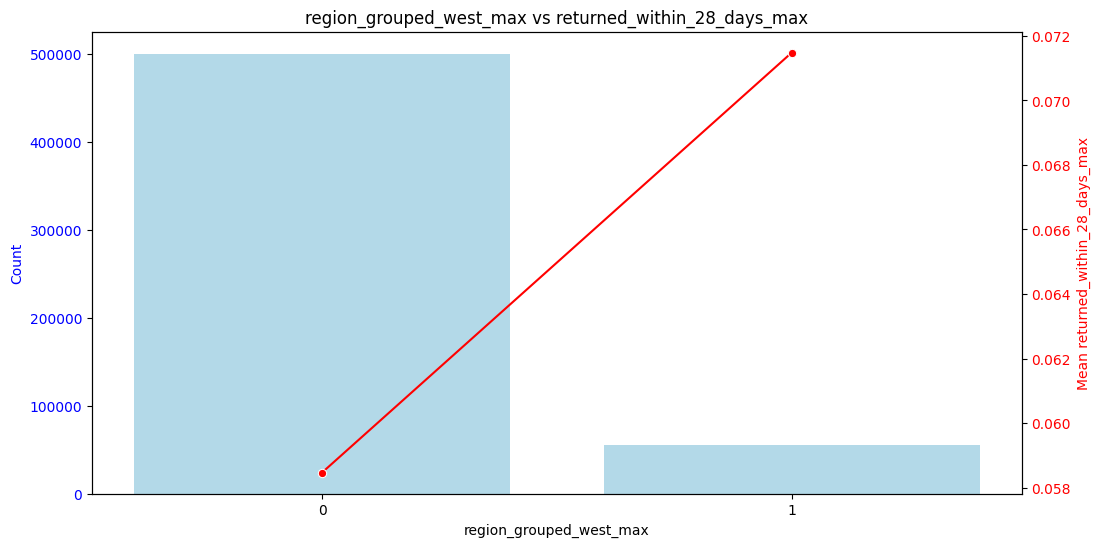

event_category_account & policy management_max
   event_category_account & policy management_max   count      mean
0                                               0  274375  0.040481
1                                               1  280385  0.078603


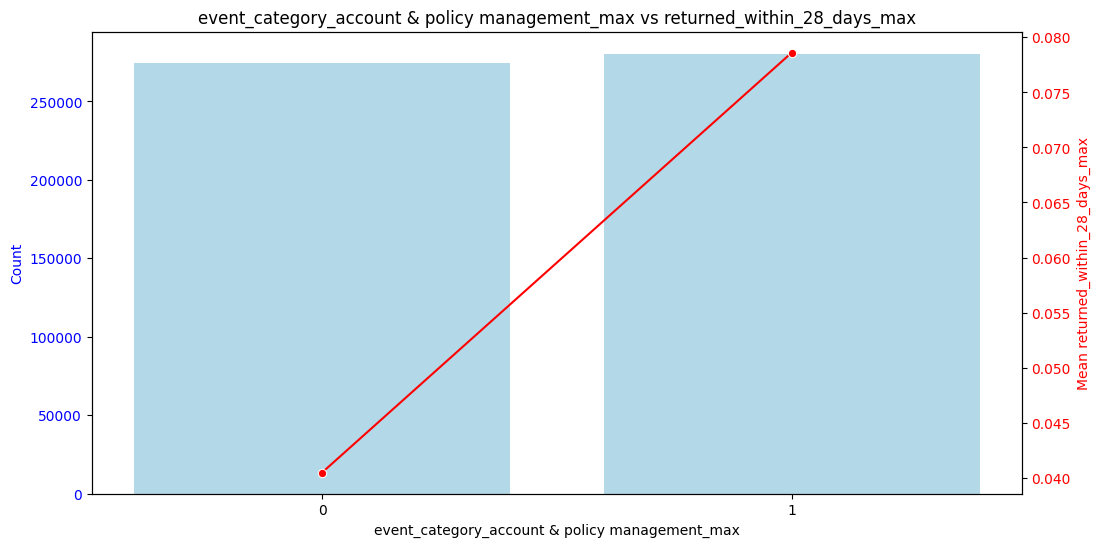

event_category_action center & workflow_max
   event_category_action center & workflow_max   count      mean
0                                            0  447866  0.060822
1                                            1  106894  0.055251


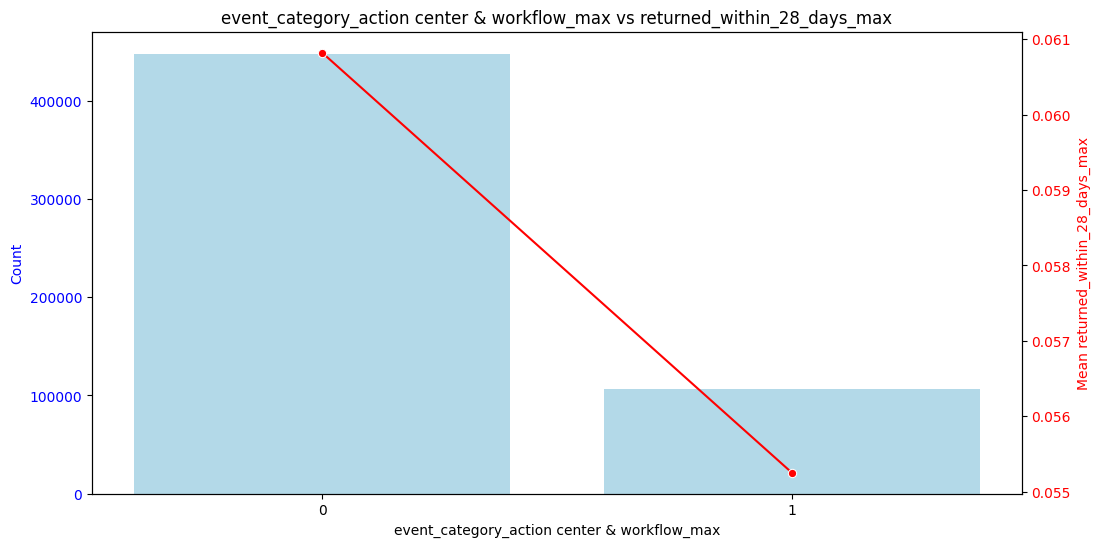

event_category_dashboard & ui interactions_max
   event_category_dashboard & ui interactions_max   count      mean
0                                               0  528974  0.059048
1                                               1   25786  0.074110


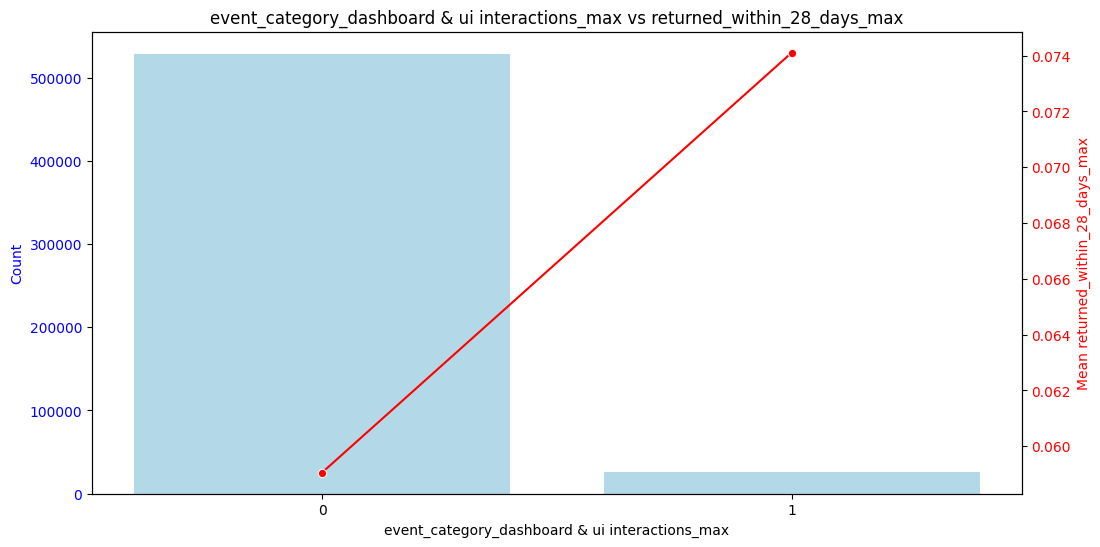

event_category_other/system events_max
   event_category_other/system events_max   count      mean
0                                       0  538307  0.059031
1                                       1   16453  0.083207


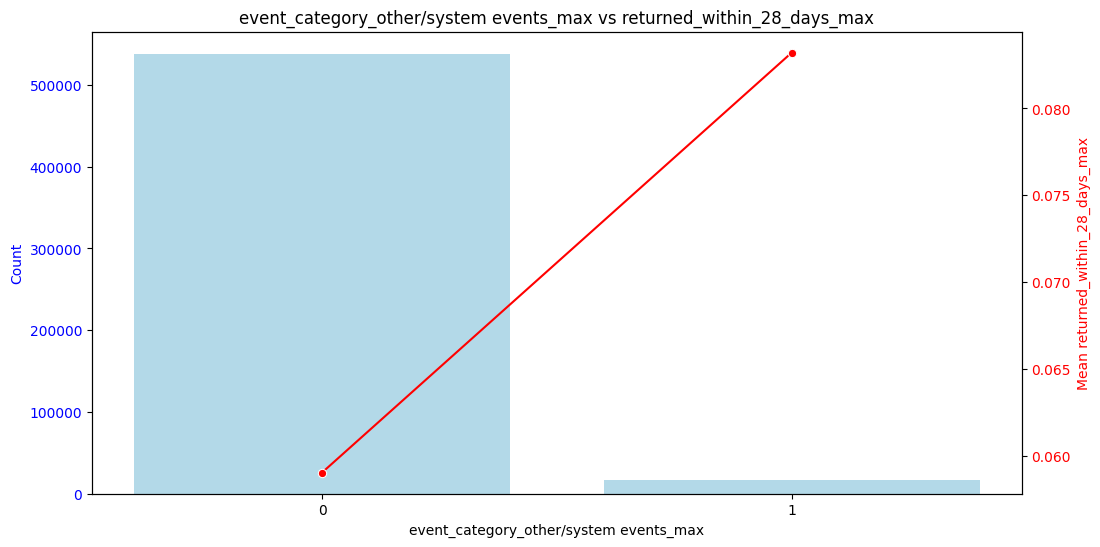

event_category_session & navigation_max
   event_category_session & navigation_max   count      mean
0                                        0   27417  0.086297
1                                        1  527343  0.058368


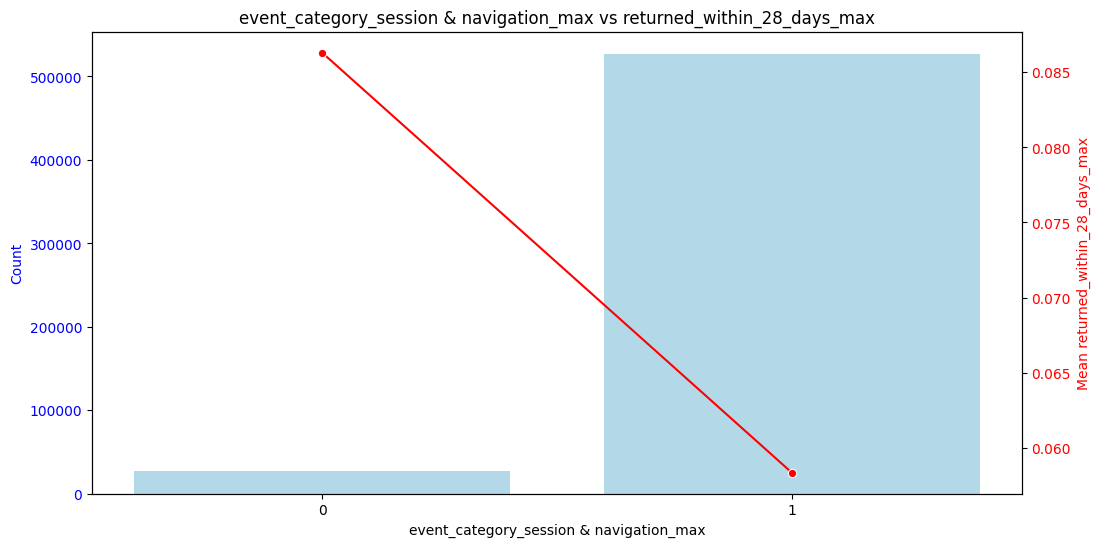

event_category_submission & forms_max
   event_category_submission & forms_max   count      mean
0                                      0  541619  0.059378
1                                      1   13141  0.075032


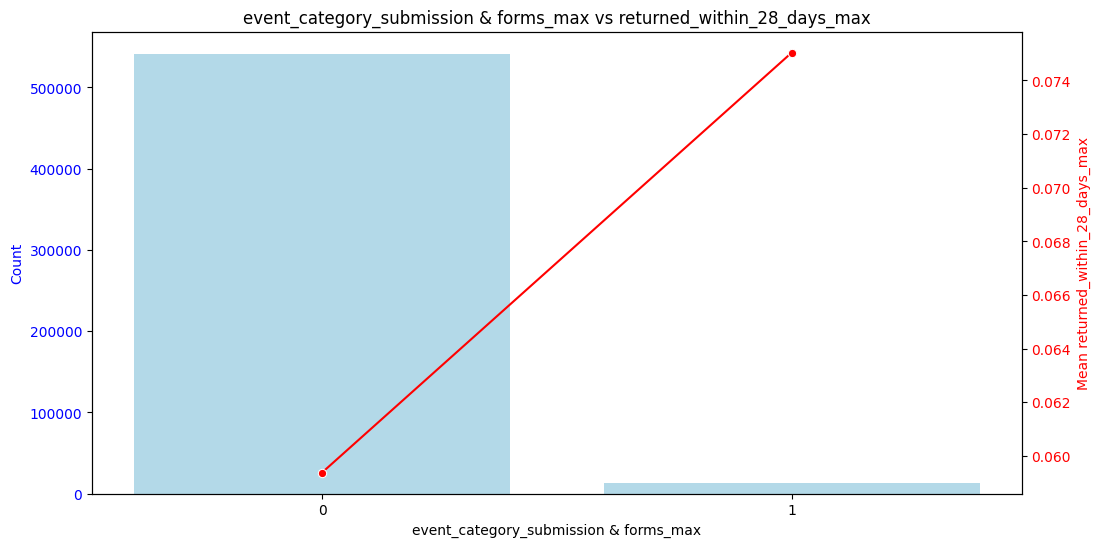

returned_within_28_days_max
uw_max
   uw_max   count      mean
0       0   54496  0.120559
1       1  500264  0.053124


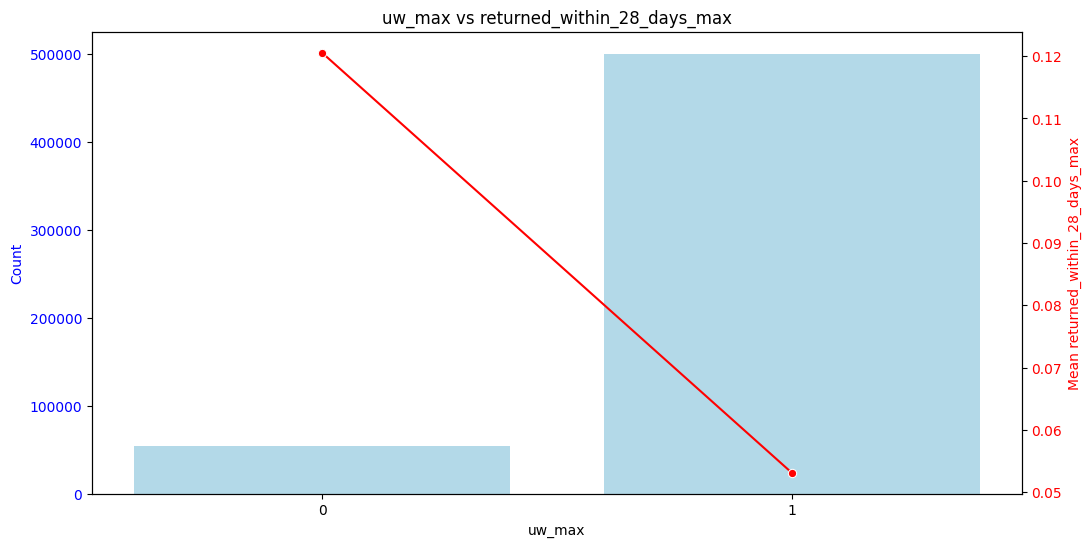

admin_max
   admin_max   count      mean
0          0  504314  0.055717
1          1   50446  0.100048


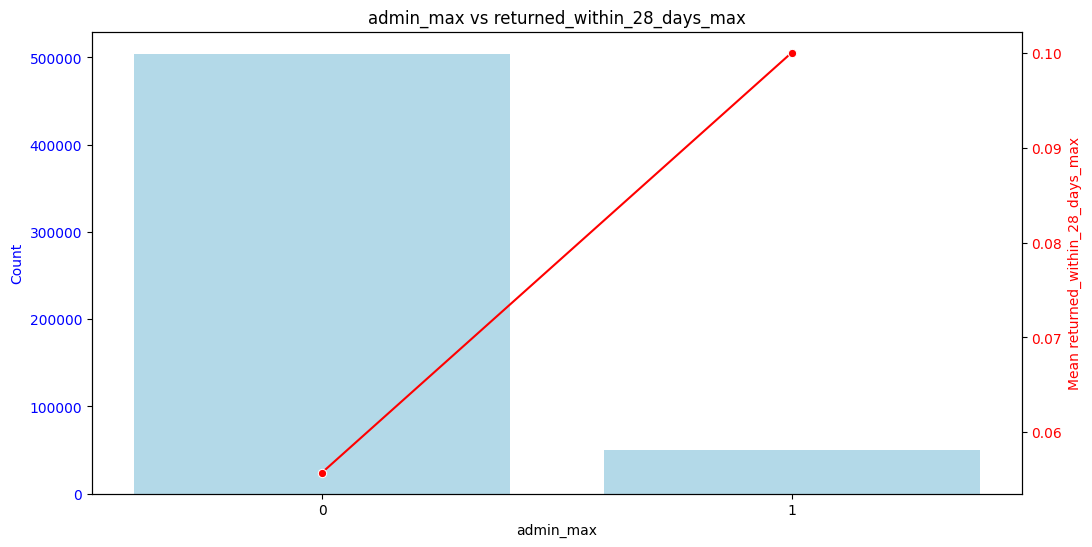

manager_max
   manager_max   count      mean
0            0  516820  0.055642
1            1   37940  0.115683


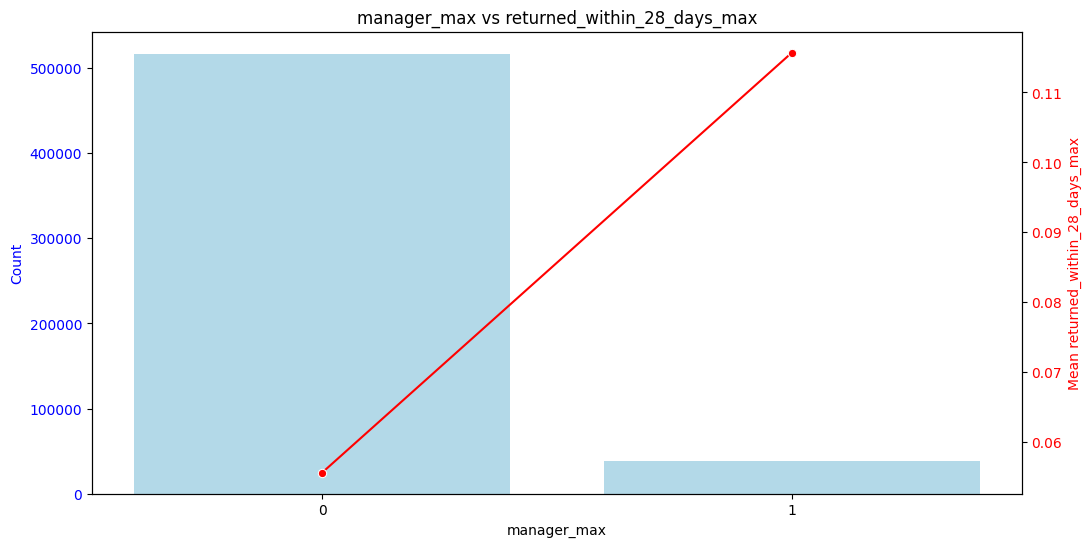

broker_max
   broker_max   count      mean
0           0  551288  0.058982
1           1    3472  0.181452


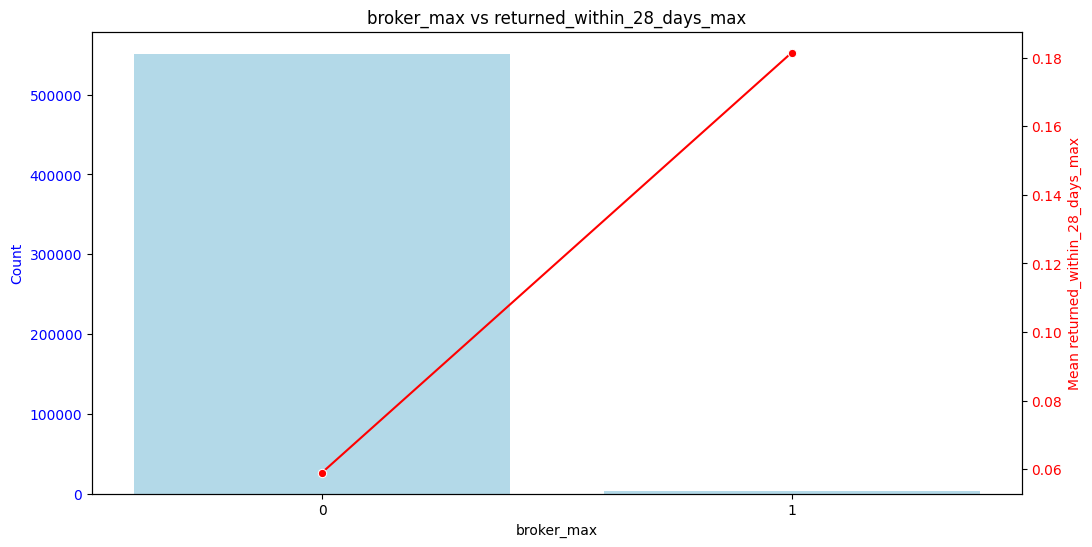

google_max
   google_max   count      mean
0           0  524542  0.061326
1           1   30218  0.032365


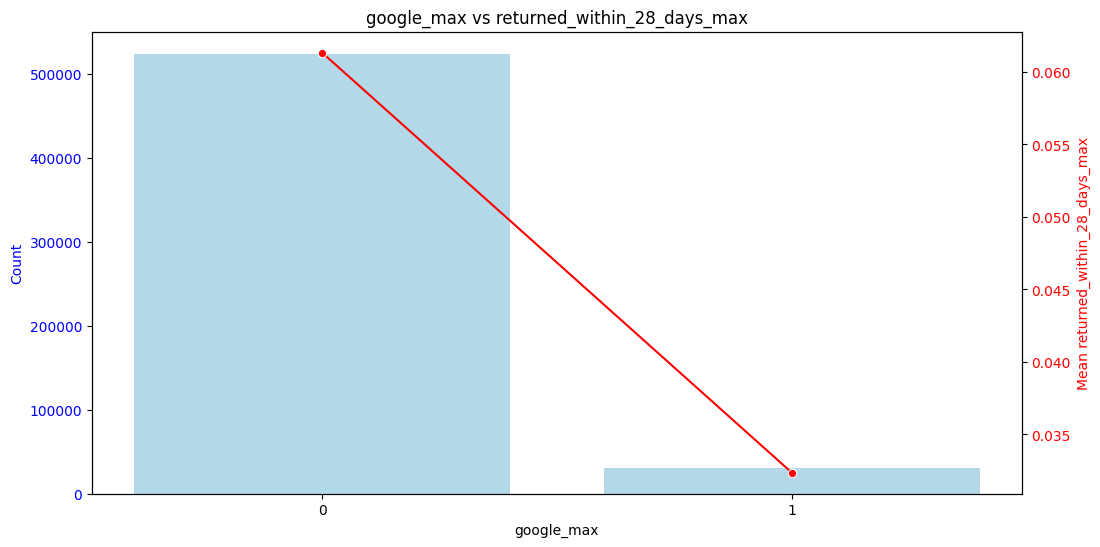

microsoft_max
   microsoft_max   count      mean
0              0  518861  0.055857
1              1   35899  0.115992


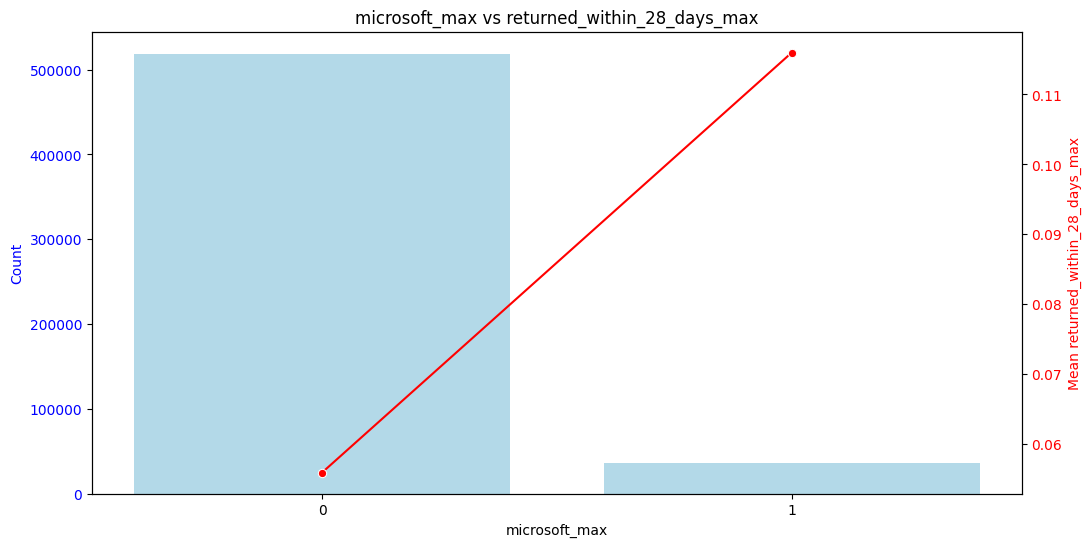

session_seconds_mean


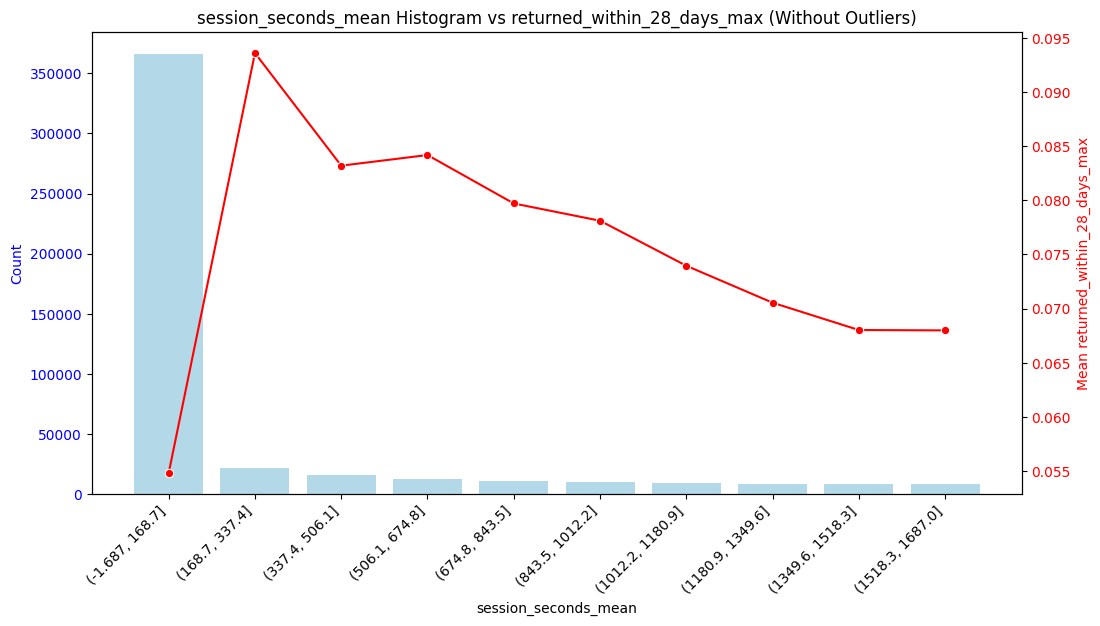

client_event_hour_mean


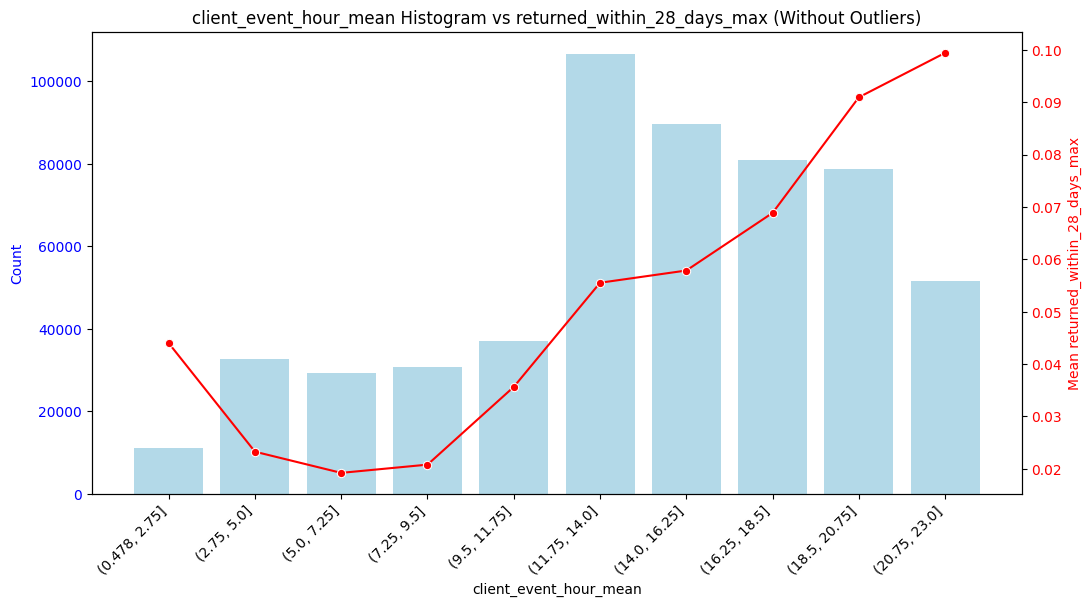

client_upload_hour_mean


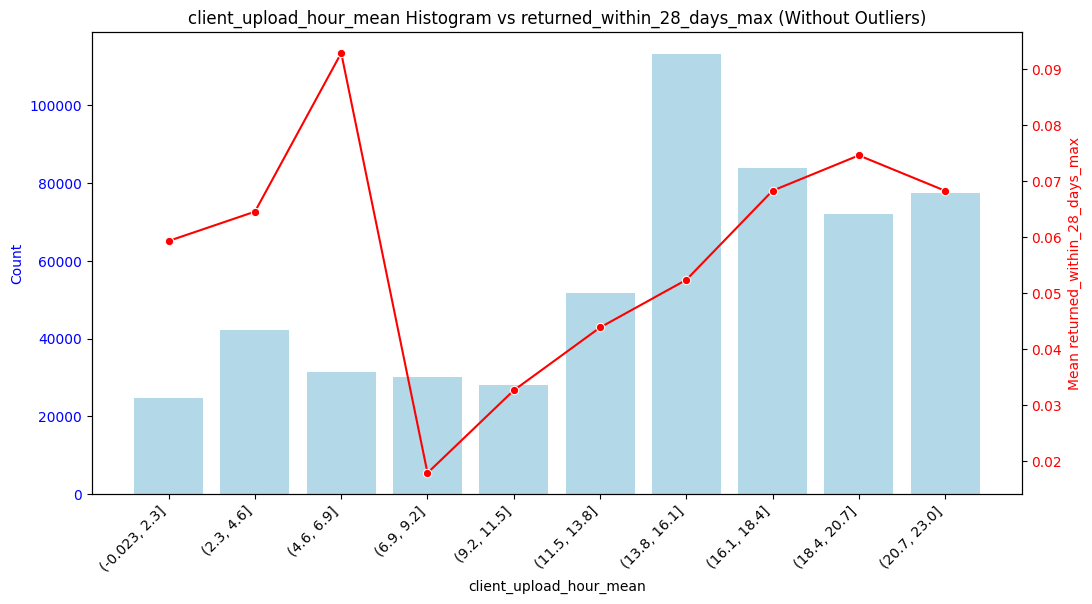

event_hour_mean


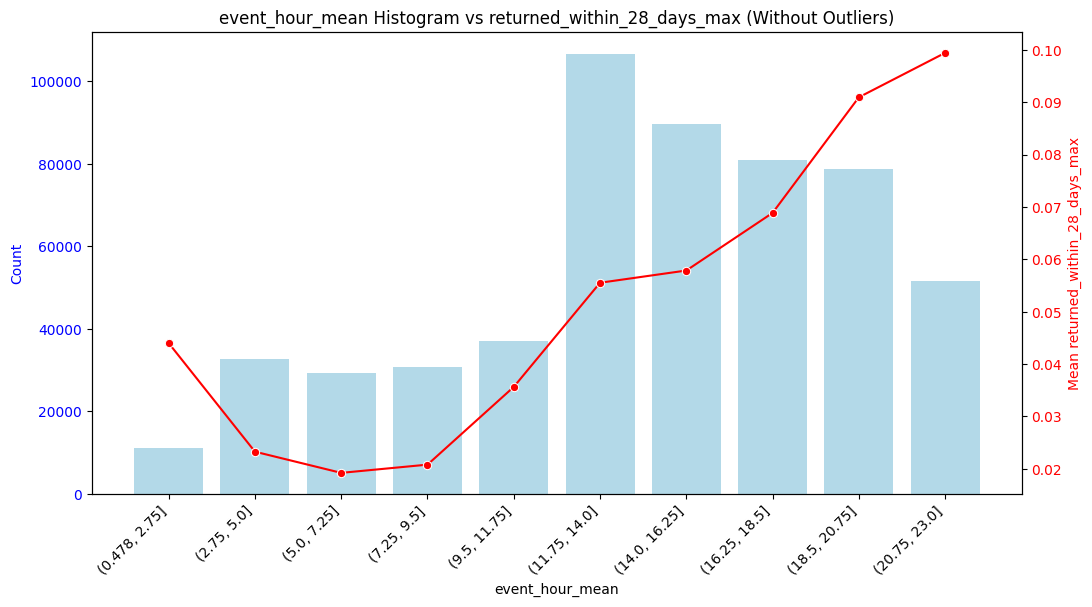

server_received_hour_mean


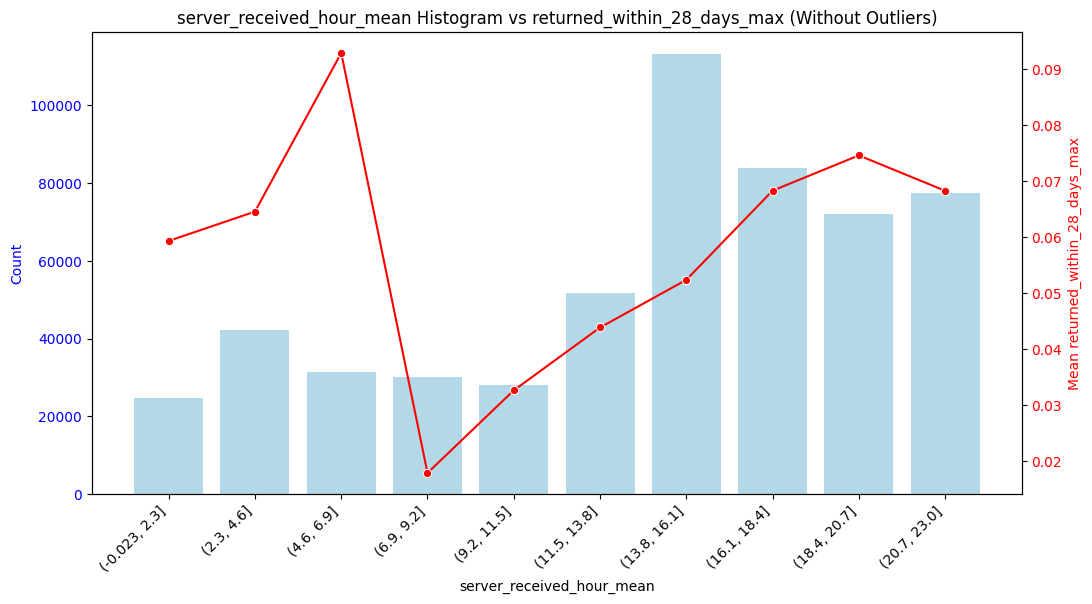

server_upload_hour_mean


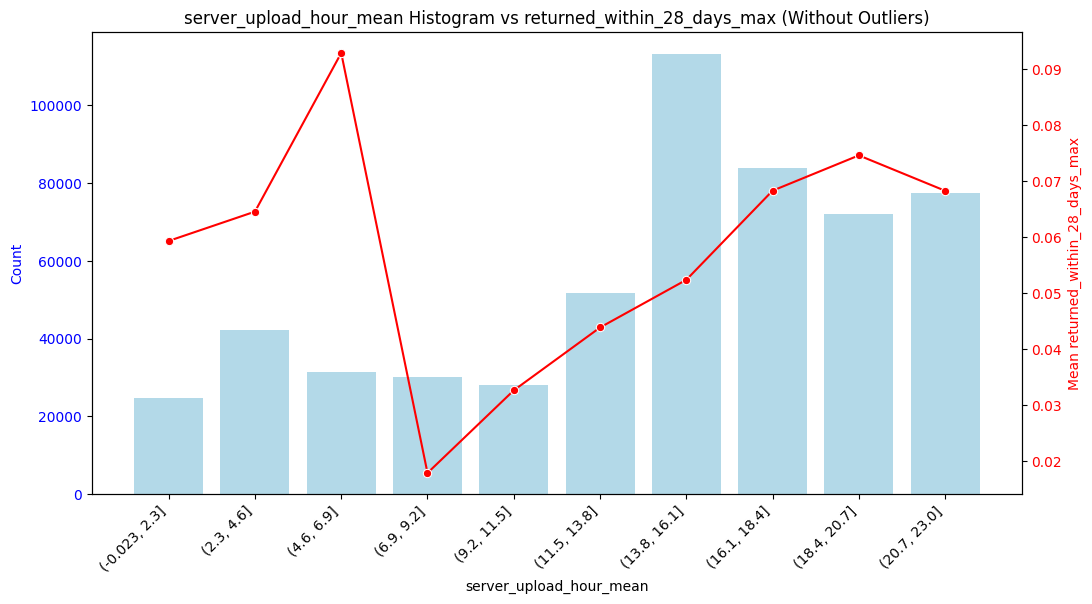

time_to_server_mean


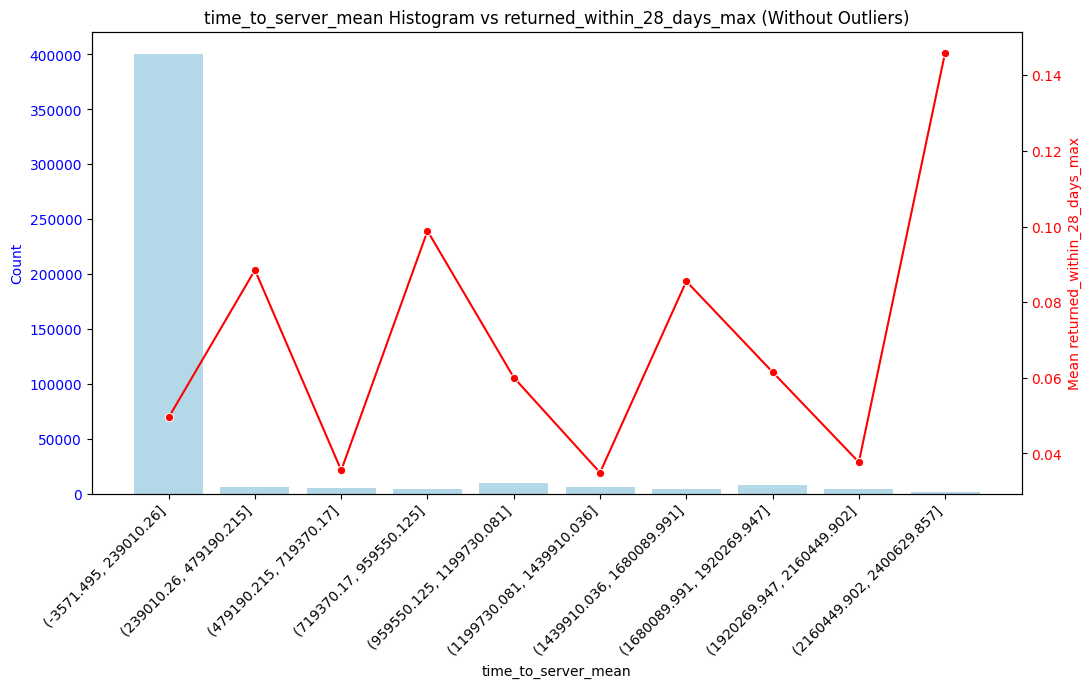

server_to_process_mean


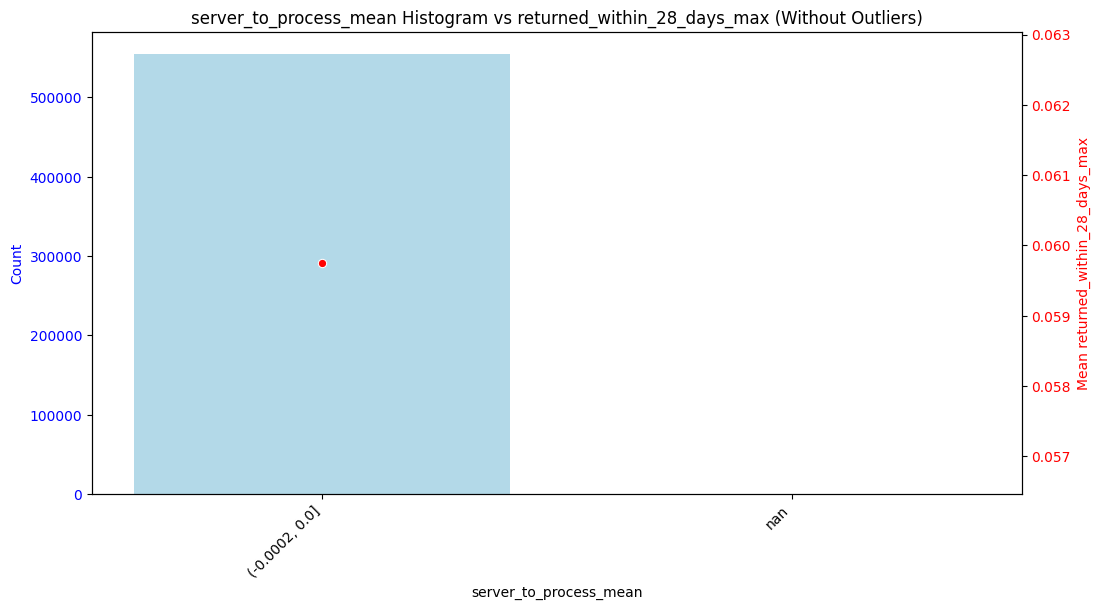

processing_time_mean


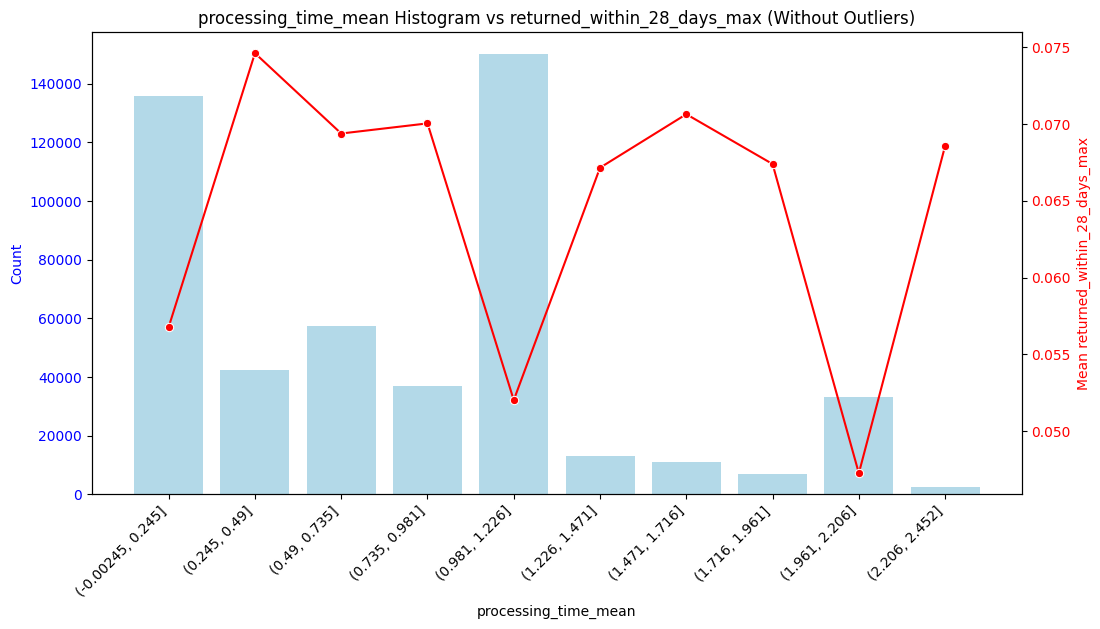

device_family_linux_max
   device_family_linux_max   count        mean
0                        0  506240  927.363141
1                        1   48520    1.076340


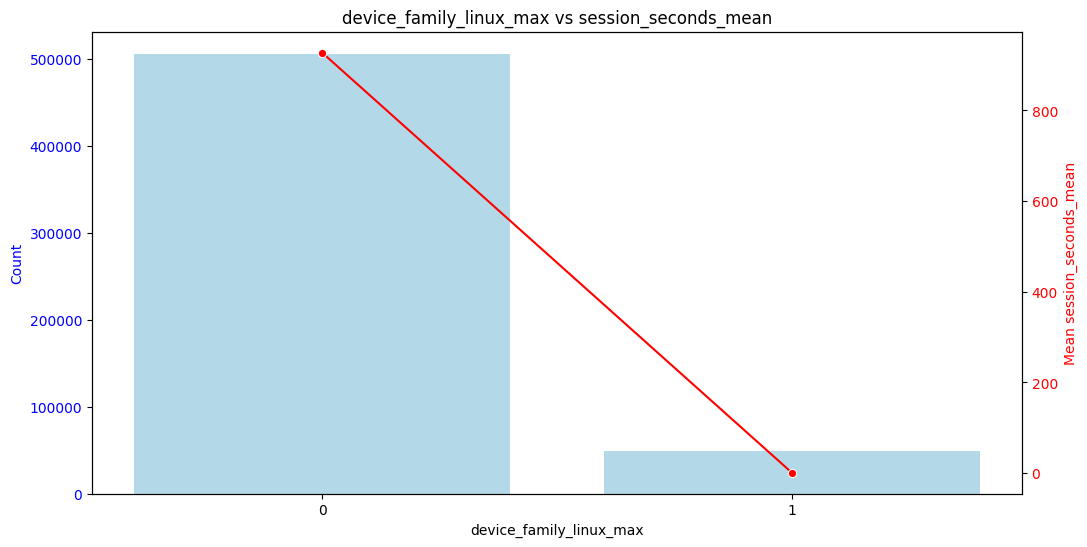

device_family_mac os x_max
   device_family_mac os x_max   count        mean
0                           0  504603  848.045834
1                           1   50157  829.277440


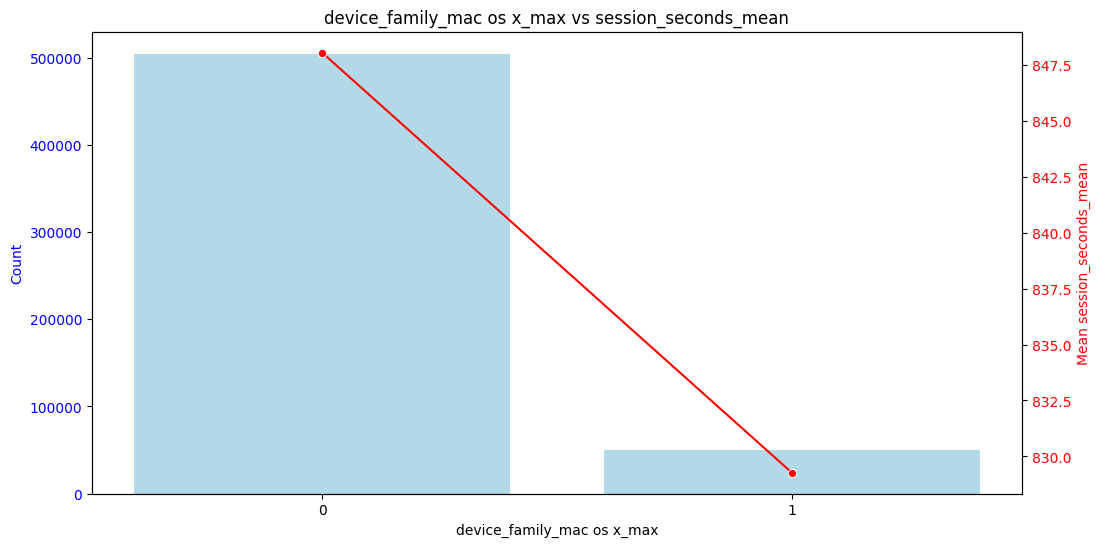

device_family_windows_max
   device_family_windows_max   count        mean
0                          0  120819  545.195369
1                          1  433941  930.196919


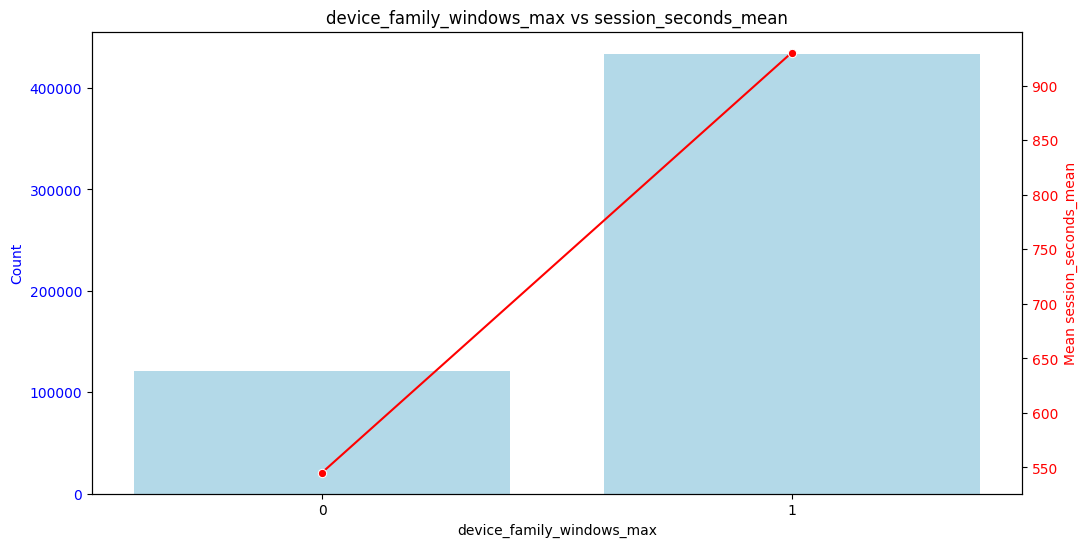

region_grouped_international_max
   region_grouped_international_max   count         mean
0                                 0  485073   767.032802
1                                 1   69687  1398.447894


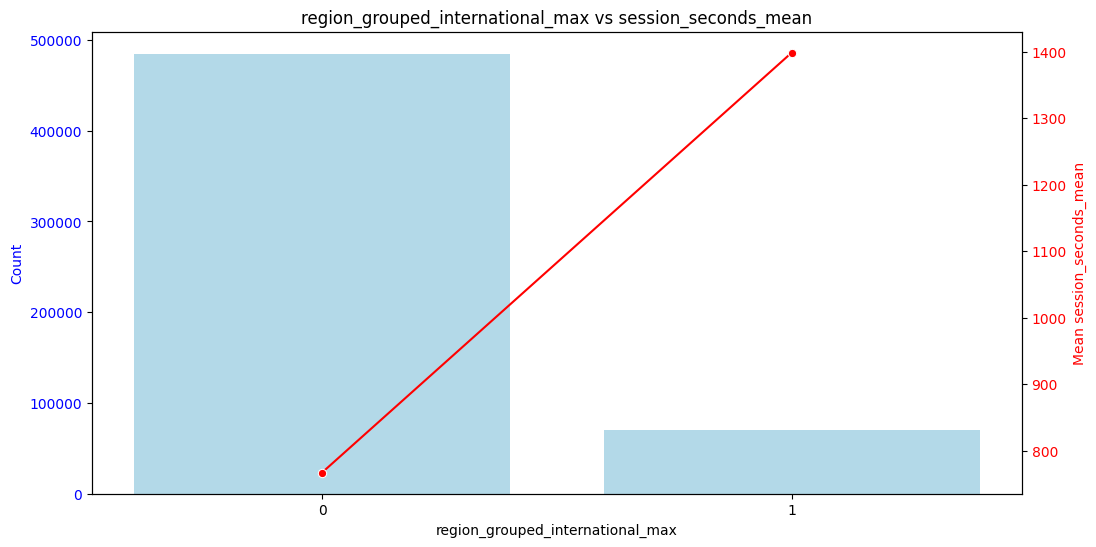

region_grouped_midwest_max
   region_grouped_midwest_max   count        mean
0                           0  464581  871.911557
1                           1   90179  714.656376


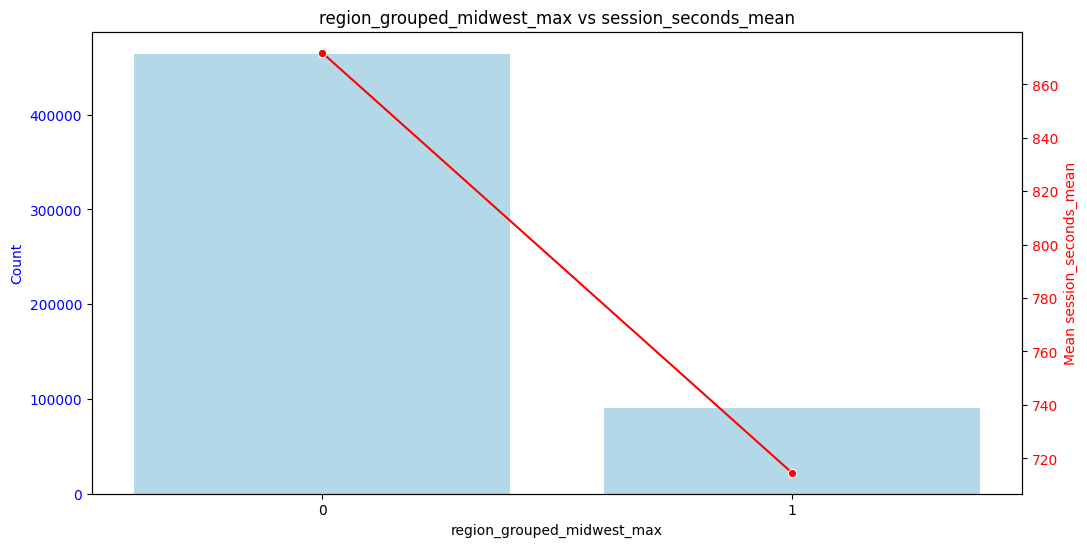

region_grouped_northeast_max
   region_grouped_northeast_max   count        mean
0                             0  519655  861.638710
1                             1   35105  620.016423


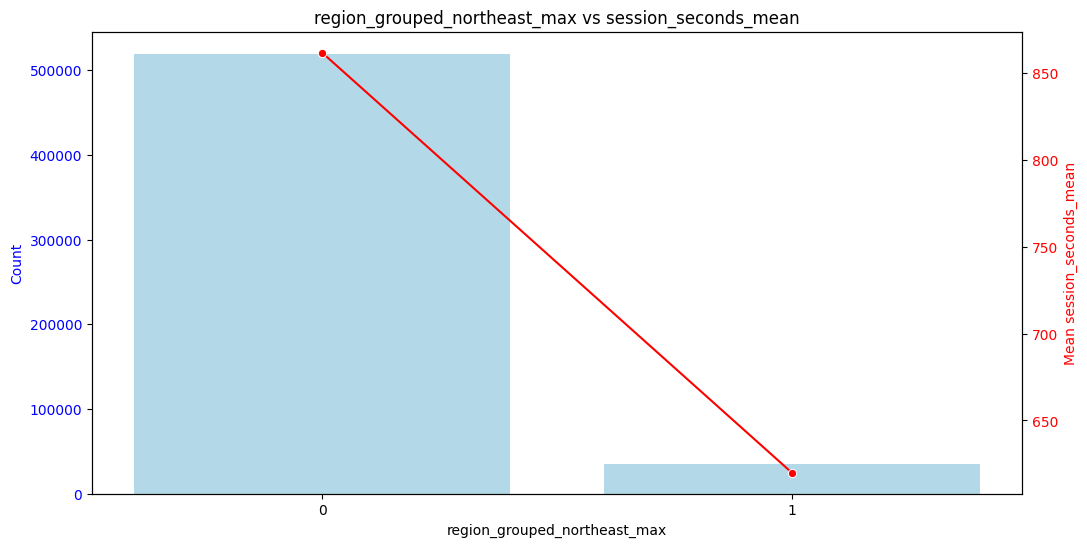

region_grouped_south_max
   region_grouped_south_max   count        mean
0                         0  247214  823.499709
1                         1  307546  864.715794


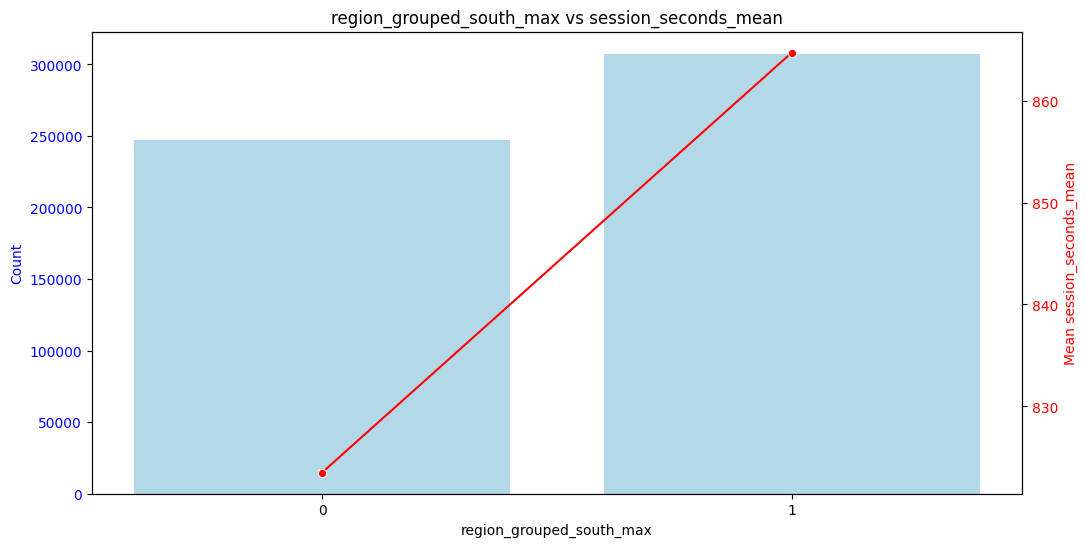

region_grouped_west_max
   region_grouped_west_max   count        mean
0                        0  500073  891.507093
1                        1   54687  433.410389


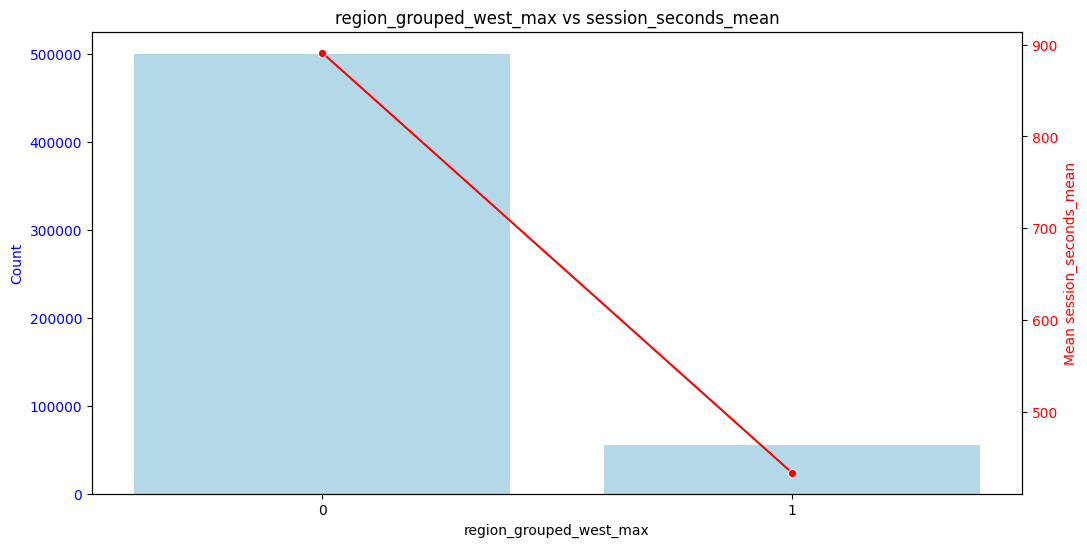

event_category_account & policy management_max
   event_category_account & policy management_max   count         mean
0                                               0  274375    97.721612
1                                               1  280385  1578.929590


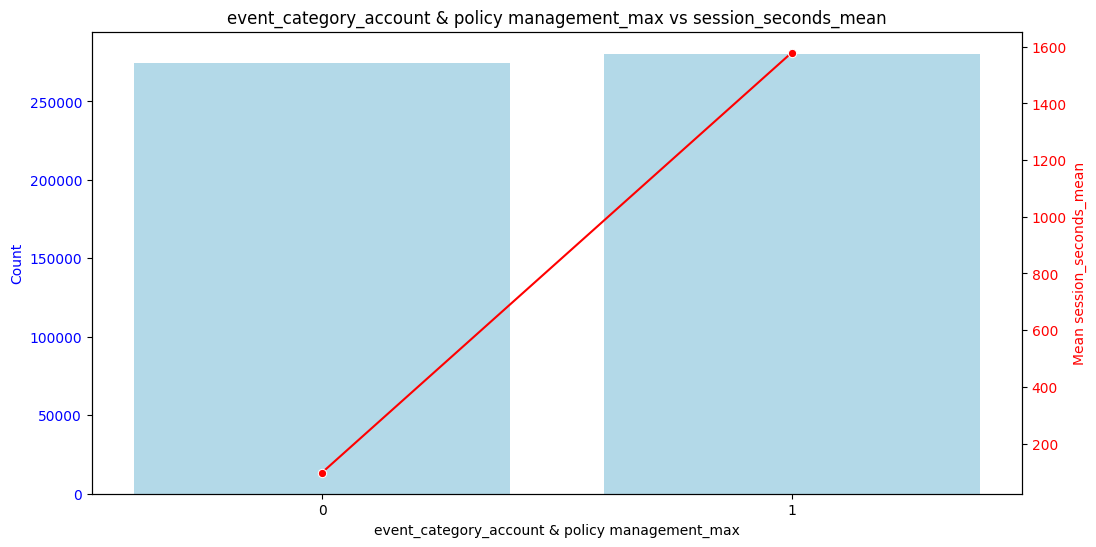

event_category_action center & workflow_max
   event_category_action center & workflow_max   count         mean
0                                            0  447866   520.350511
1                                            1  106894  2212.221813


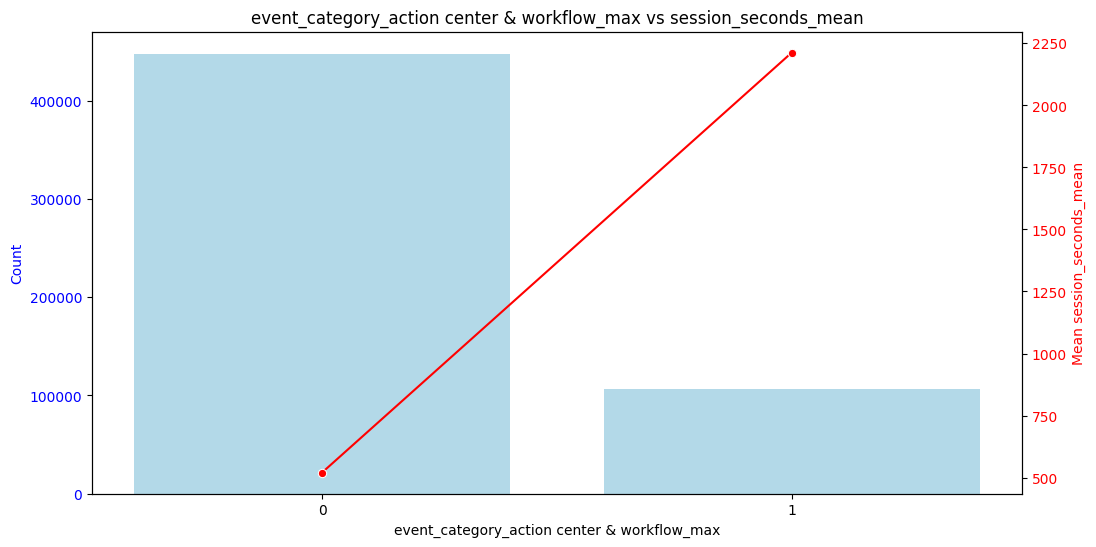

event_category_dashboard & ui interactions_max
   event_category_dashboard & ui interactions_max   count         mean
0                                               0  528974   798.662800
1                                               1   25786  1824.582504


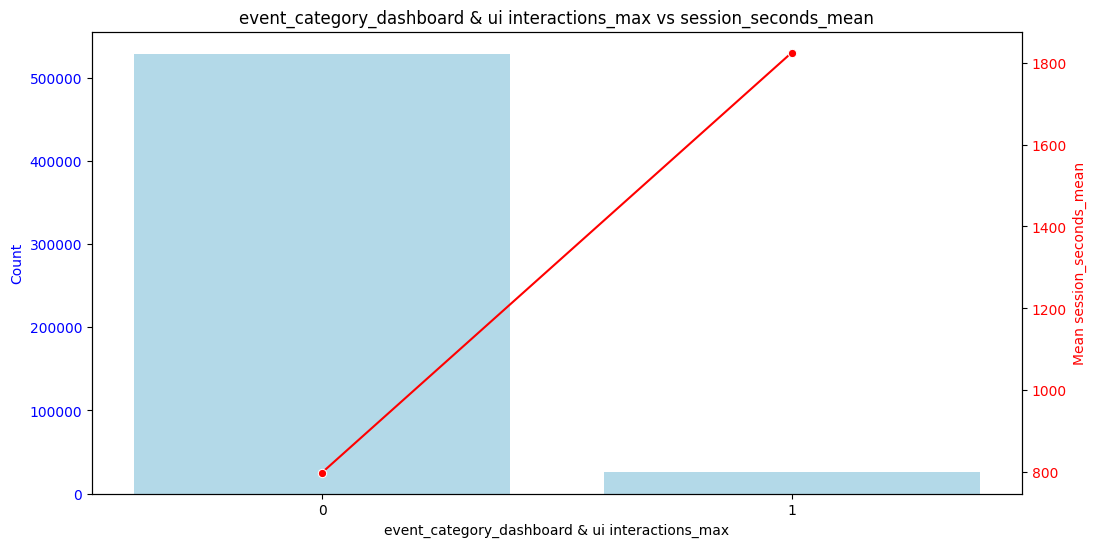

event_category_other/system events_max
   event_category_other/system events_max   count         mean
0                                       0  538307   835.542940
1                                       1   16453  1199.898324


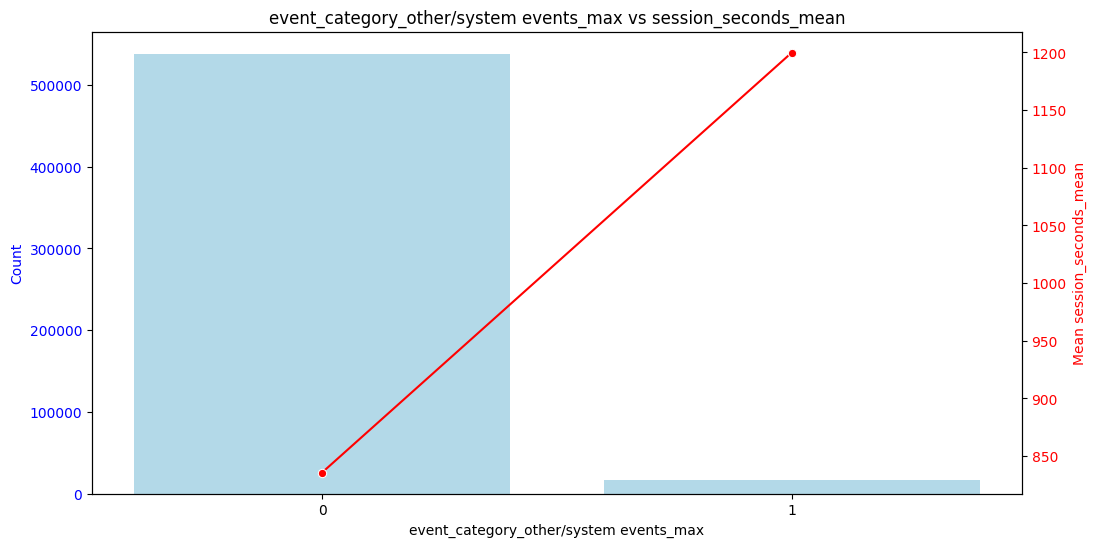

event_category_session & navigation_max
   event_category_session & navigation_max   count        mean
0                                        0   27417  694.334719
1                                        1  527343  854.252290


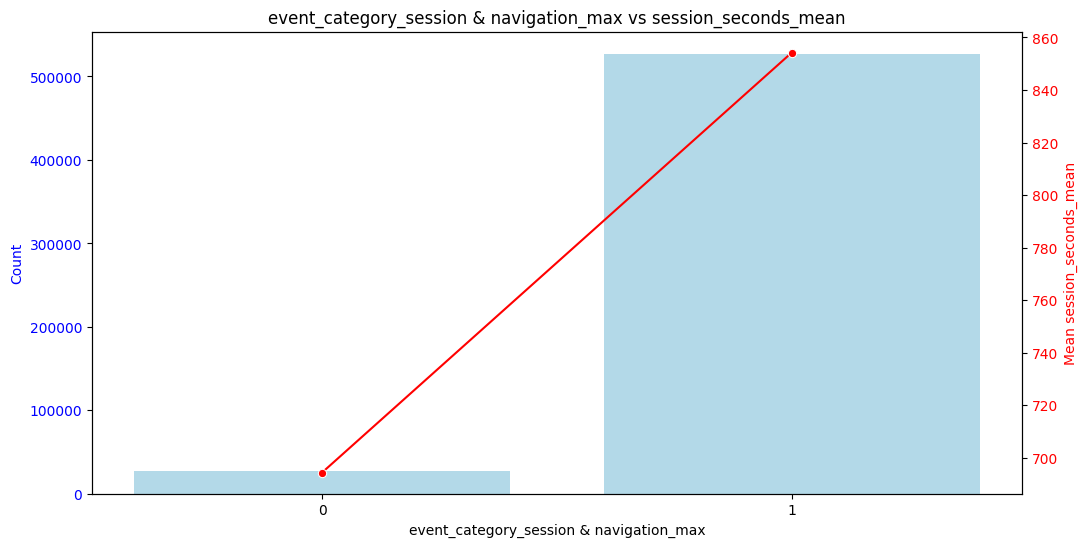

event_category_submission & forms_max
   event_category_submission & forms_max   count         mean
0                                      0  541619   773.724645
1                                      1   13141  3839.629566


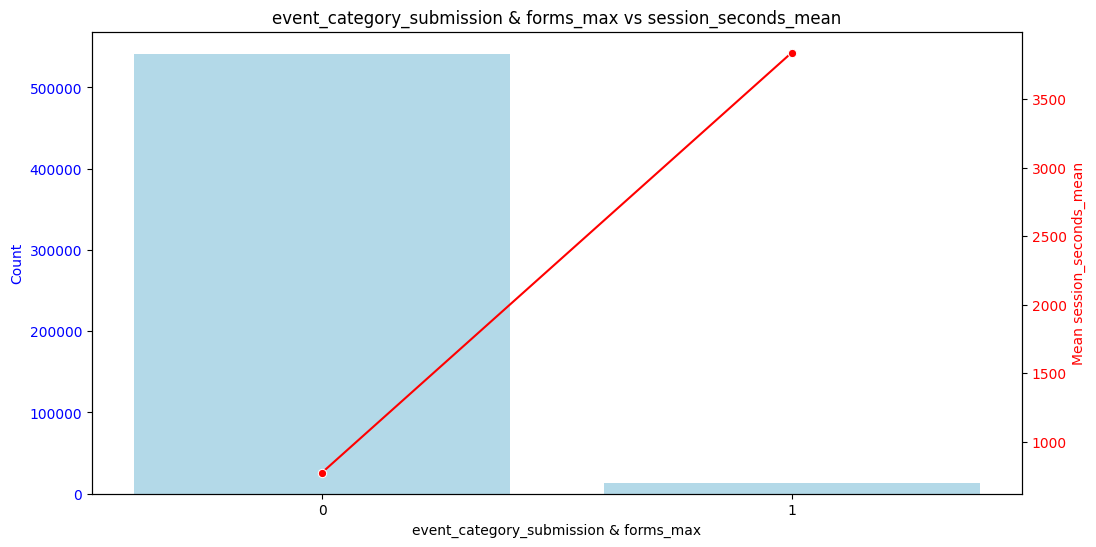

returned_within_28_days_max
   returned_within_28_days_max   count        mean
0                            0  521614  845.898216
1                            1   33146  853.441999


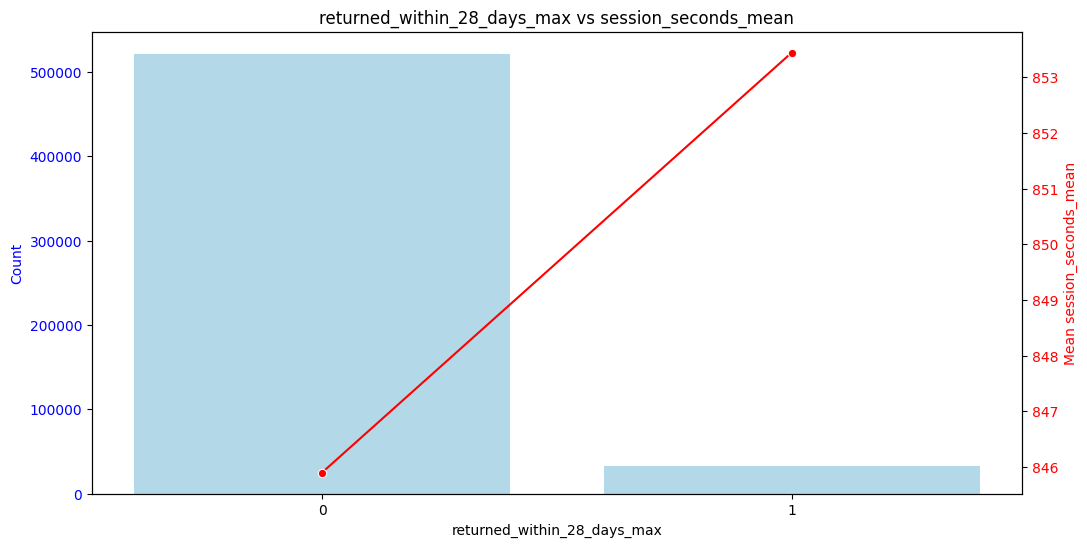

uw_max
   uw_max   count        mean
0       0   54496  736.073884
1       1  500264  858.361701


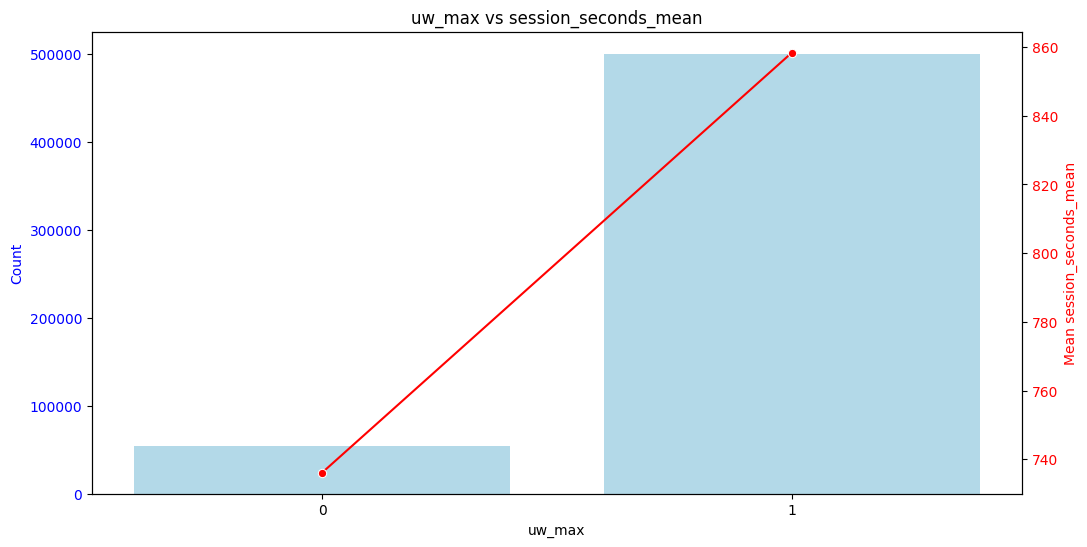

admin_max
   admin_max   count        mean
0          0  504314  864.232212
1          1   50446  667.568031


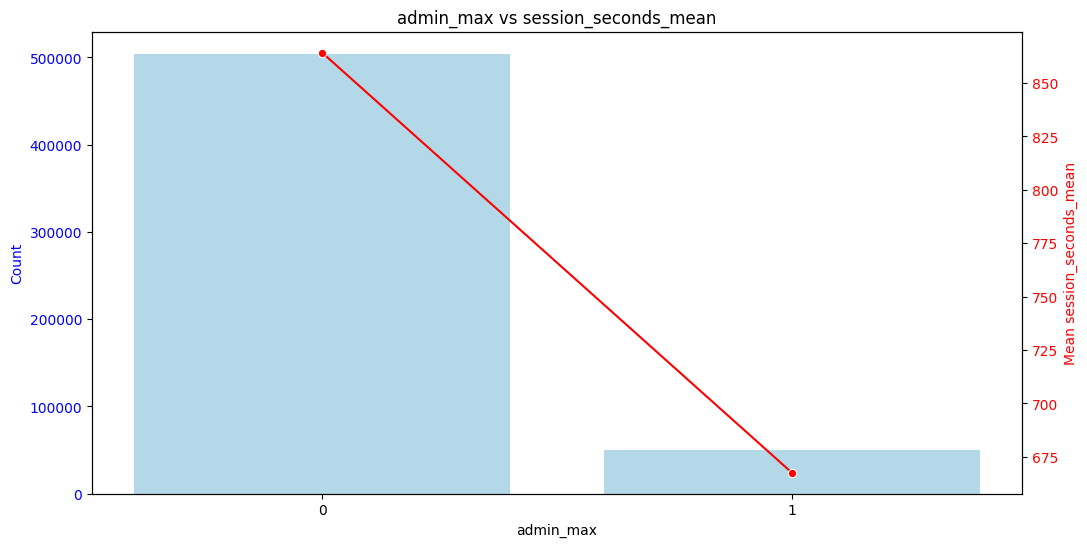

manager_max
   manager_max   count        mean
0            0  516820  844.664014
1            1   37940  869.301130


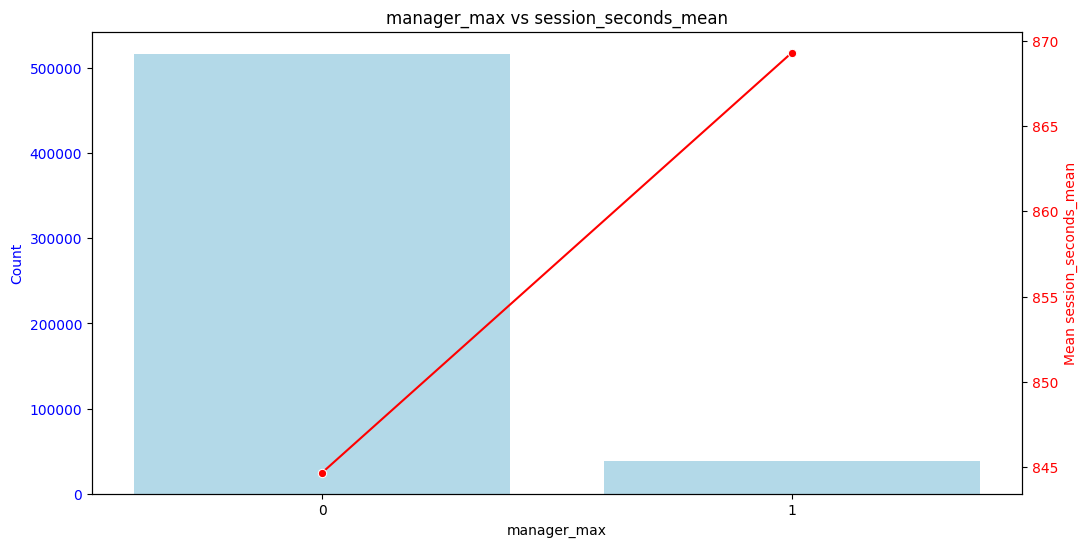

broker_max
   broker_max   count        mean
0           0  551288  849.629517
1           1    3472  325.456028


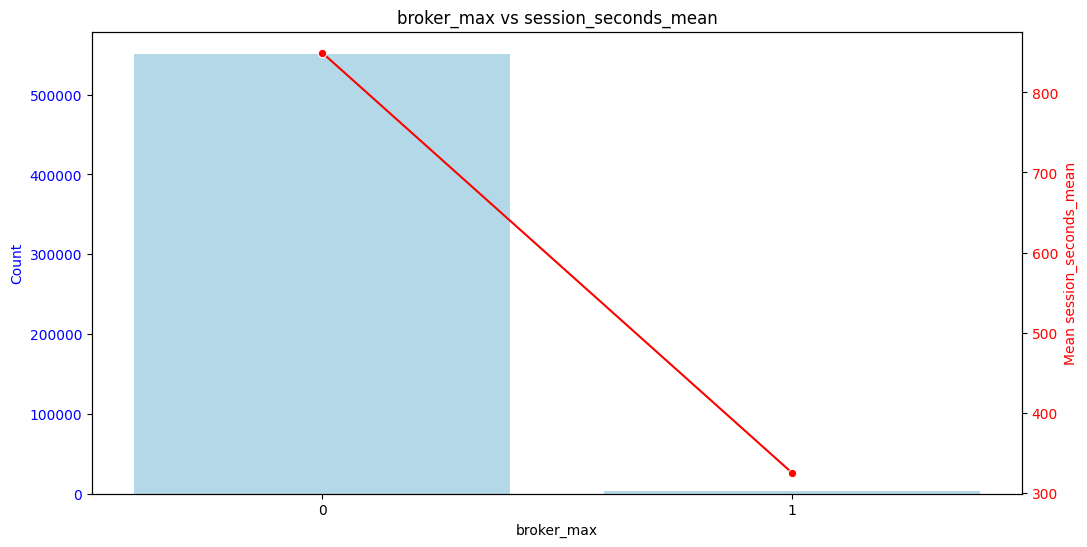

google_max
   google_max   count        mean
0           0  524542  838.431552
1           1   30218  983.783750


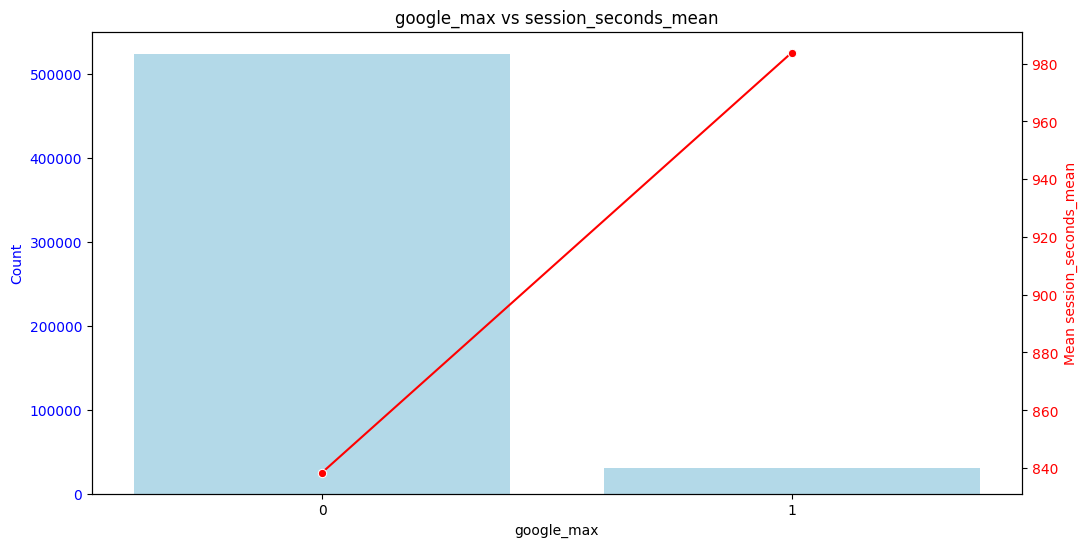

microsoft_max
   microsoft_max   count        mean
0              0  518861  868.349479
1              1   35899  528.367401


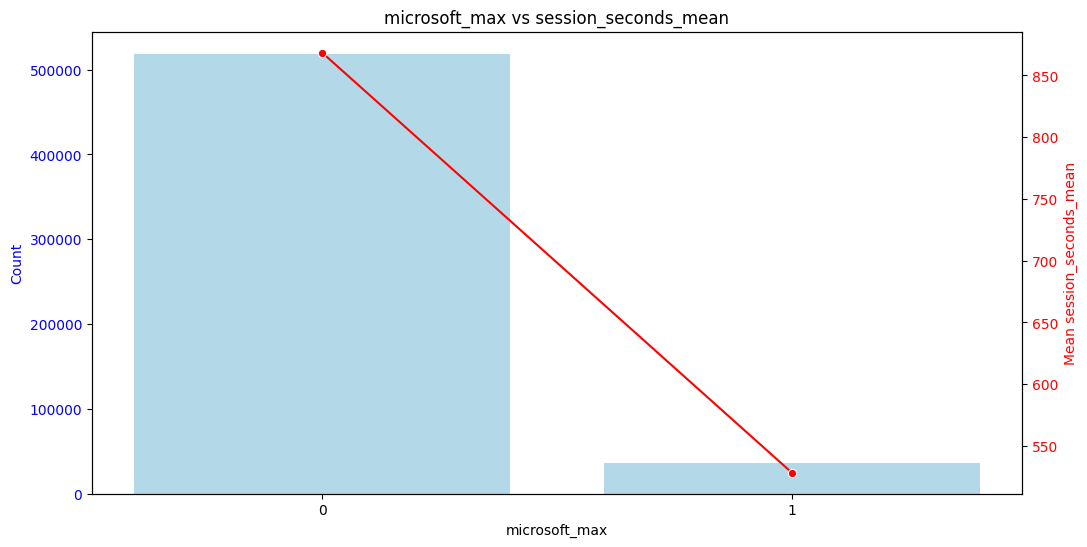

session_seconds_mean
client_event_hour_mean


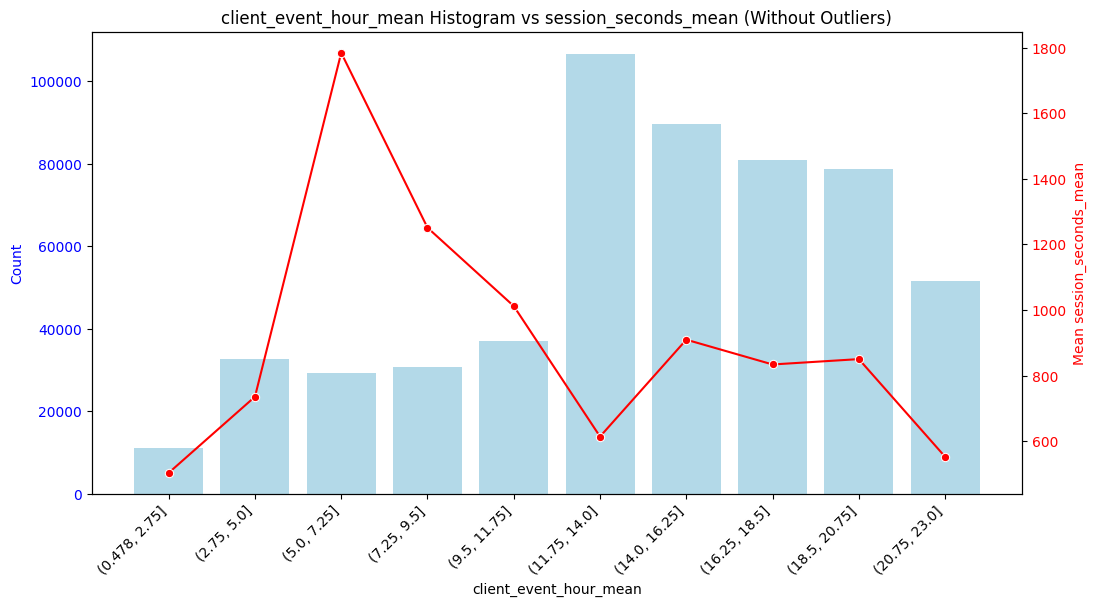

client_upload_hour_mean


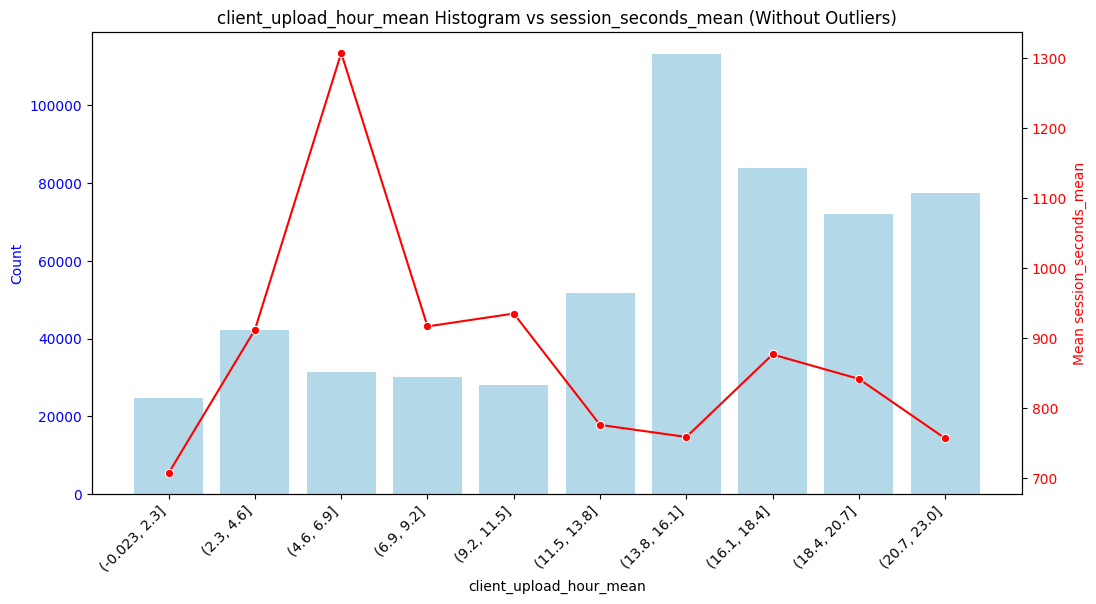

event_hour_mean


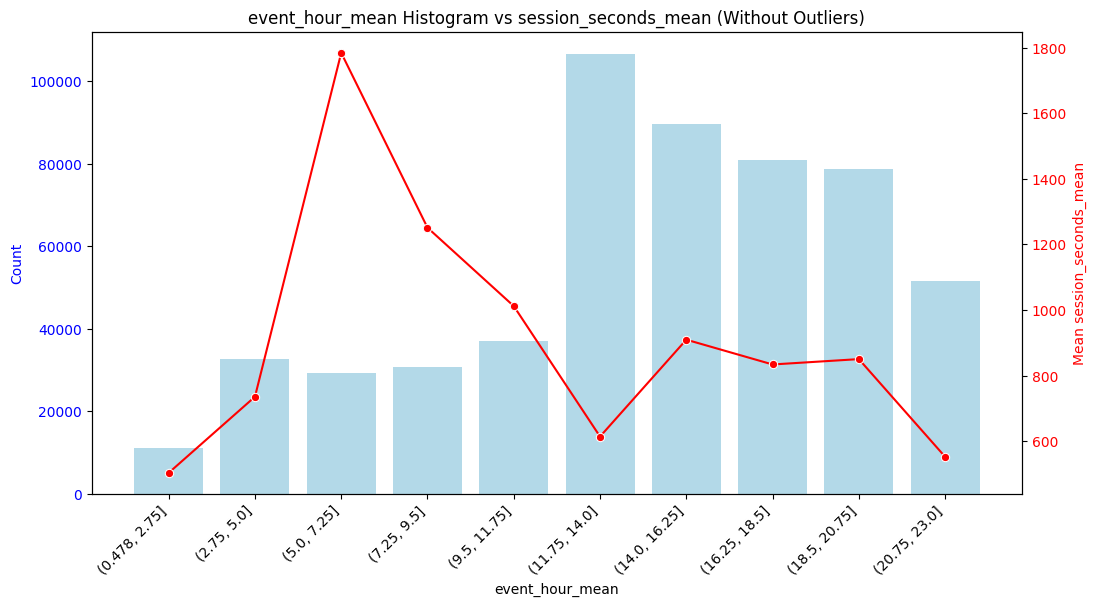

server_received_hour_mean


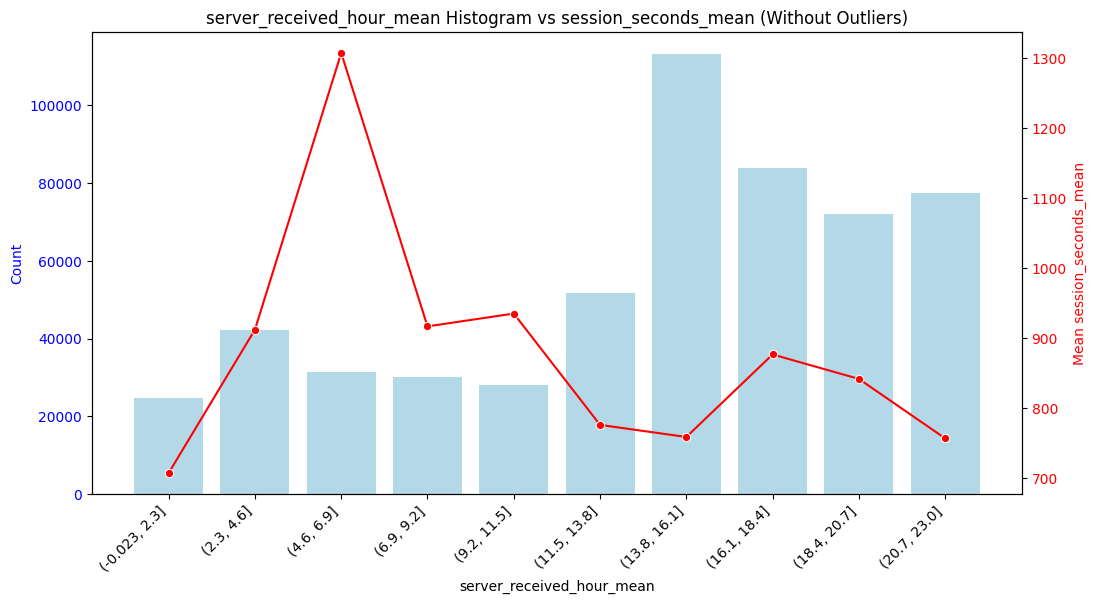

server_upload_hour_mean


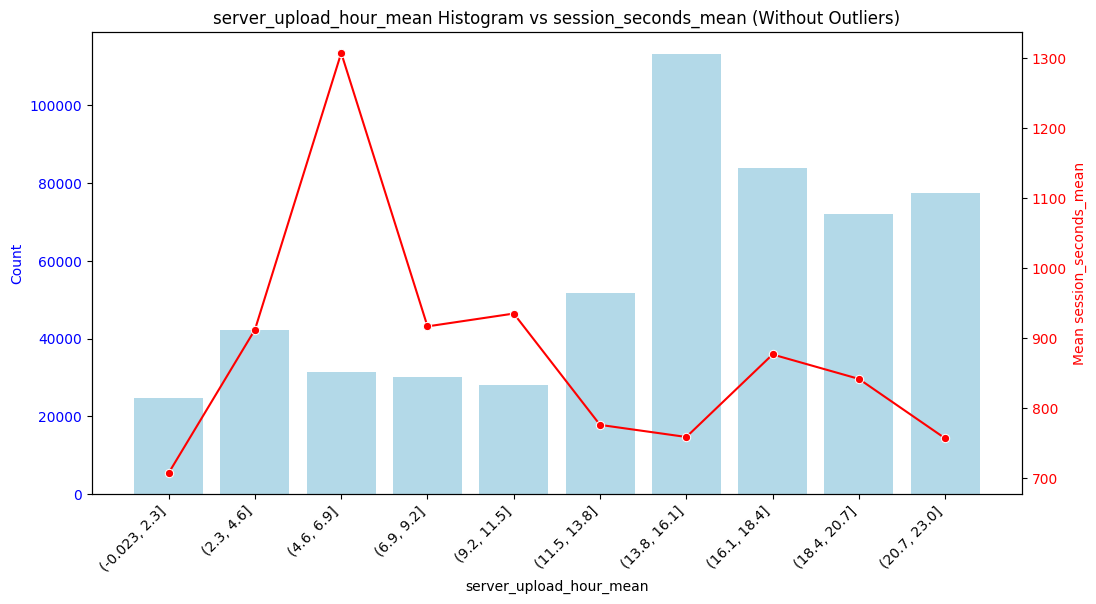

time_to_server_mean


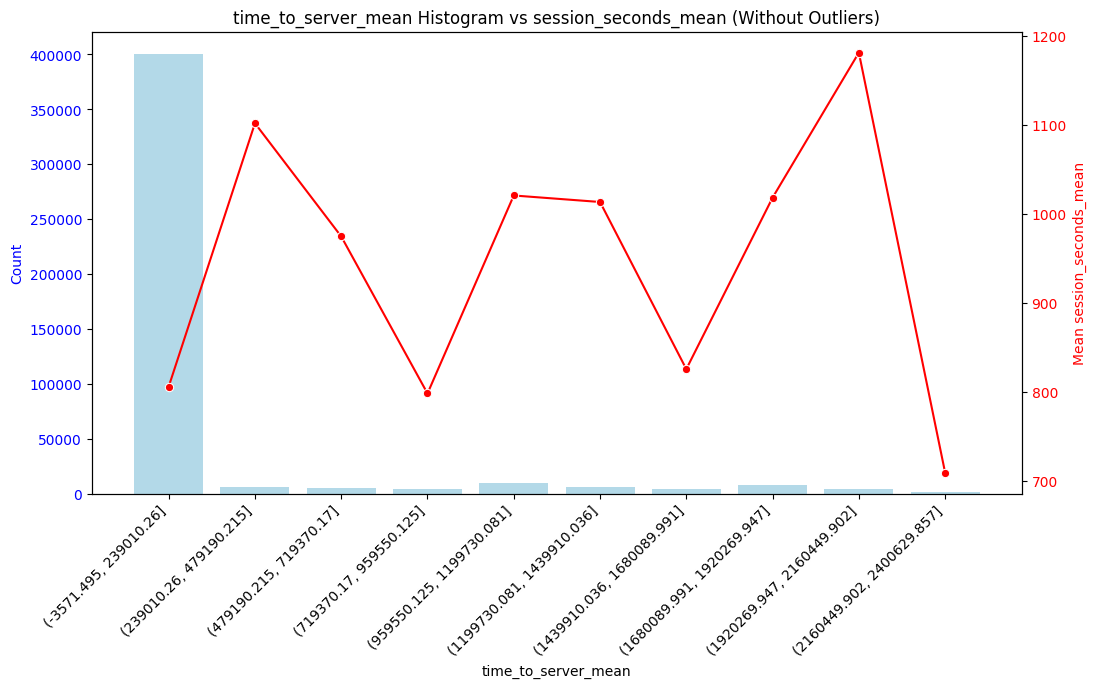

server_to_process_mean


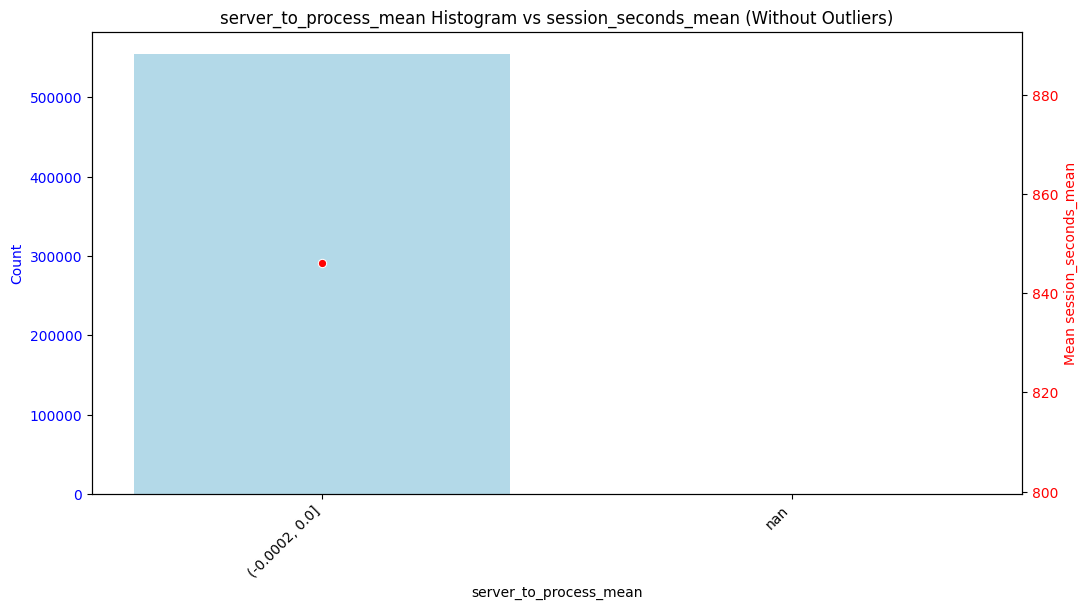

processing_time_mean


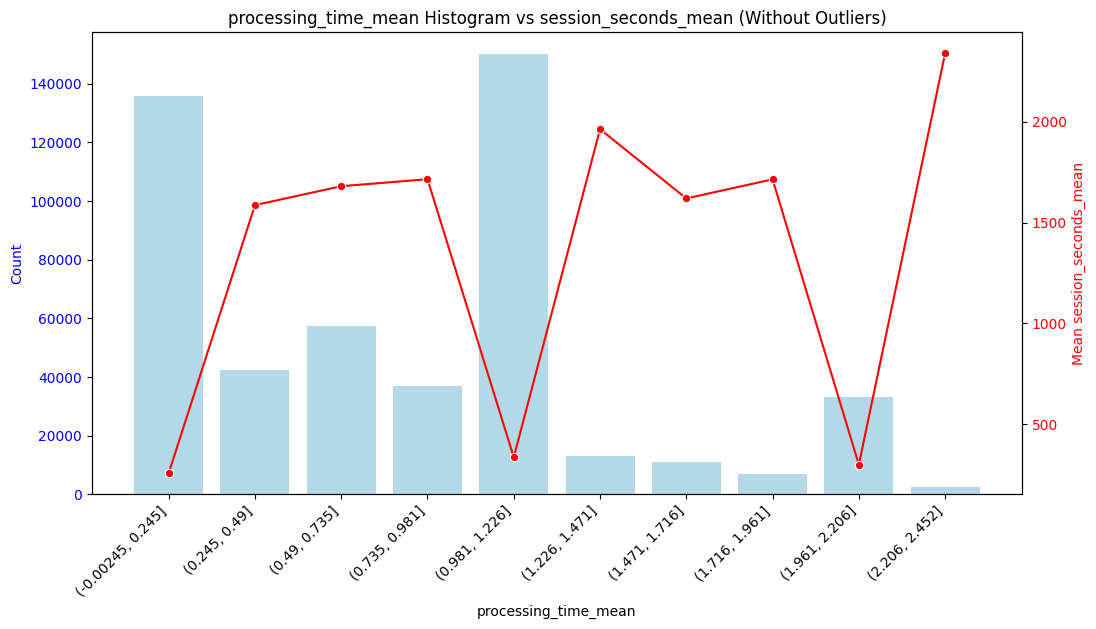

In [66]:
def plot_features_with_target(df, target_col):
    for column in df.columns[2:]:
        print(column)
        if column == target_col:
            continue
        
        # Categorical columns: Bar plot with mean target on secondary y-axis
        if df[column].nunique() == 2:
            plot_categorical_vs_target(df, column, target_col)
        
        # Numerical columns: Histogram with mean target as secondary y-axis
        else:
            plot_hist_vs_target(df, column, target_col)

plot_features_with_target(df, 'returned_within_28_days_max')
plot_features_with_target(df, 'session_seconds_mean')

# EDA against target before aggregating

In [62]:
df = pd.read_csv('/kaggle/input/eda-dataset/federato_test_run.csv')

In [63]:
# Define the mapping for U.S. states to regions
us_region_mapping = {
    'Northeast': ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'New Jersey', 'New York', 'Pennsylvania', 'Rhode Island', 'Vermont'],
    'Midwest': ['Illinois', 'Indiana', 'Iowa', 'Kansas', 'Michigan', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'Ohio', 'South Dakota', 'Wisconsin'],
    'South': ['Alabama', 'Arkansas', 'Delaware', 'Florida', 'Georgia', 'Kentucky', 'Louisiana', 'Maryland', 'Mississippi', 'North Carolina', 'Oklahoma', 'South Carolina', 'Tennessee', 'Texas', 'Virginia', 'West Virginia'],
    'West': ['Alaska', 'Arizona', 'California', 'Colorado', 'Hawaii', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Oregon', 'Utah', 'Washington', 'Wyoming']
}

# Create a function to assign region or 'international'
def assign_region(state):
    # Check if the state is in one of the U.S. regions
    for region, states in us_region_mapping.items():
        if state in states:
            return region
    # If not in U.S. regions, categorize as 'international'
    return 'International'

# Apply function to the dataset
df['region_grouped'] = df['region'].apply(assign_region)
df.head()

,Unnamed: 0,client_event_time,client_upload_time,country,dma,event_time,event_type,library,processed_time,region,...,event_category_Filtering & Searching,event_category_Other/System Events,event_category_Session & Navigation,event_category_Submission & Forms,region_grouped_International,region_grouped_Midwest,region_grouped_Northeast,region_grouped_South,region_grouped_West,region_grouped
0,0,2024-08-08 17:46:48.104,2024-08-08 17:46:49.182,United States,"Houston, TX",2024-08-08 17:46:48.104,account-lines::configurable-table:render,amplitude-ts/2.7.2,2024-08-08 17:46:49.620,Texas,...,0,0,0,0,0,0,0,1,0,South
1,1,2024-12-02 16:06:46.635,2024-12-02 16:06:42.722,United States,"Chicago, IL",2024-12-02 16:06:46.635,account-lines::widget:render,amplitude-ts/2.7.2,2024-12-02 16:06:43.196,Illinois,...,0,0,0,0,0,1,0,0,0,Midwest
2,2,2024-05-07 14:21:46.420,2024-05-07 14:21:48.801,United States,"Grand Rapids-Kalamazoo, MI",2024-05-07 14:21:46.420,account:::view,amplitude-ts/1.8.0,2024-05-07 14:21:49.898,Michigan,...,0,0,0,0,0,1,0,0,0,Midwest
3,3,2024-08-05 12:54:53.734,2024-08-05 12:54:56.905,United States,"Kansas City, MO",2024-08-05 12:54:53.734,dashboard:my-book:configurable-table:render,amplitude-ts/2.7.2,2024-08-05 12:54:59.003,Missouri,...,0,0,1,0,0,1,0,0,0,Midwest
4,4,2024-08-15 15:25:26.079,2024-08-15 15:25:26.137,United States,"Chicago, IL",2024-08-15 15:25:26.079,account-lines::configurable-table:render,amplitude-ts/2.7.2,2024-08-15 15:25:26.688,Illinois,...,0,0,0,0,0,1,0,0,0,Midwest


In [64]:
def categorize_event(event_type):
    if any(keyword in event_type for keyword in ["session_start", "session_end", "application-window", "nav-header", "dashboard"]):
        return "Session & Navigation"
    elif any(keyword in event_type for keyword in ["account", "policy", "rating"]):
        return "Account & Policy Management"
    elif any(keyword in event_type for keyword in ["dashboard", "widget", "layout", "insights", "table"]):
        return "Dashboard & UI Interactions"
    elif any(keyword in event_type for keyword in ["action-center", "task", "workflow", "take-action"]):
        return "Action Center & Workflow"
    elif any(keyword in event_type for keyword in ["submit-click", "form", "create", "definition", "save-click", "submissions"]):
        return "Submission & Forms"
    elif any(keyword in event_type for keyword in ["filter", "sort", "search", "advanced-filters"]):
        return "Filtering & Searching"
    elif any(keyword in event_type for keyword in ["document", "report", "download", "csv"]):
        return "Document & Report Interactions"
    else:
        return "Other/System Events"
# Applying function to dataset
df["event_category"] = df["event_type"].apply(categorize_event)
df.head()

,Unnamed: 0,client_event_time,client_upload_time,country,dma,event_time,event_type,library,processed_time,region,...,event_category_Other/System Events,event_category_Session & Navigation,event_category_Submission & Forms,region_grouped_International,region_grouped_Midwest,region_grouped_Northeast,region_grouped_South,region_grouped_West,region_grouped,event_category
0,0,2024-08-08 17:46:48.104,2024-08-08 17:46:49.182,United States,"Houston, TX",2024-08-08 17:46:48.104,account-lines::configurable-table:render,amplitude-ts/2.7.2,2024-08-08 17:46:49.620,Texas,...,0,0,0,0,0,0,1,0,South,Account & Policy Management
1,1,2024-12-02 16:06:46.635,2024-12-02 16:06:42.722,United States,"Chicago, IL",2024-12-02 16:06:46.635,account-lines::widget:render,amplitude-ts/2.7.2,2024-12-02 16:06:43.196,Illinois,...,0,0,0,0,1,0,0,0,Midwest,Account & Policy Management
2,2,2024-05-07 14:21:46.420,2024-05-07 14:21:48.801,United States,"Grand Rapids-Kalamazoo, MI",2024-05-07 14:21:46.420,account:::view,amplitude-ts/1.8.0,2024-05-07 14:21:49.898,Michigan,...,0,0,0,0,1,0,0,0,Midwest,Account & Policy Management
3,3,2024-08-05 12:54:53.734,2024-08-05 12:54:56.905,United States,"Kansas City, MO",2024-08-05 12:54:53.734,dashboard:my-book:configurable-table:render,amplitude-ts/2.7.2,2024-08-05 12:54:59.003,Missouri,...,0,1,0,0,1,0,0,0,Midwest,Session & Navigation
4,4,2024-08-15 15:25:26.079,2024-08-15 15:25:26.137,United States,"Chicago, IL",2024-08-15 15:25:26.079,account-lines::configurable-table:render,amplitude-ts/2.7.2,2024-08-15 15:25:26.688,Illinois,...,0,0,0,0,1,0,0,0,Midwest,Account & Policy Management


In [65]:
df['slug'] = df['slug'].fillna('NaN')

In [66]:
df['uw'] = df['roles'].str.contains("underwriter")
df['admin'] = df['roles'].str.contains("admin")
df['manager'] = df['roles'].str.contains("manager")
df['broker'] = df['roles'].str.contains("Broker")

df.loc[df['slug'].str.isnumeric(), 'slug'] = 'numeric'
df.loc[df['slug'].str.startswith("account"), 'slug'] = 'account'
df.loc[df['slug'].str.startswith("email-inbox"), 'slug'] = 'email-inbox'
df.loc[df['slug'].str.startswith(("excess", "Excess")), 'slug'] = 'excess'
df.loc[df['slug'].str.startswith("form"), 'slug'] = 'form'
df.loc[df['slug'].str.startswith("limits"), 'slug'] = 'limits'
df.loc[df['slug'].str.startswith("locations"), 'slug'] = 'locations'
df.loc[df['slug'].str.startswith("loss"), 'slug'] = 'loss'
df.loc[df['slug'].str.startswith("policy"), 'slug'] = 'policy'
df.loc[df['slug'].str.startswith("submission"), 'slug'] = 'submission'
df.loc[df['slug'].str.startswith("table"), 'slug'] = 'table'
df.loc[df['slug'].str.contains("access-control"), 'slug'] = 'access-control'
df.loc[df['slug'].str.contains("accounts"), 'slug'] = 'accounts'
df.loc[df['slug'].str.contains("action"), 'slug'] = 'action'
df.loc[df['slug'].str.contains("additional"), 'slug'] = 'additional'
df.loc[df['slug'].str.contains("agency"), 'slug'] = 'agency'
df.loc[df['slug'].str.contains("ah"), 'slug'] = 'ah'
df.loc[df['slug'].str.contains("all-bordereaux"), 'slug'] = 'all-bordereaux'
df.loc[df['slug'].str.contains("auto"), 'slug'] = 'auto'
df.loc[df['slug'].str.contains("aviation|fleet"), 'slug'] = 'aviation'
df.loc[df['slug'].str.contains("bond"), 'slug'] = 'bond'
df.loc[df['slug'].str.contains("broker"), 'slug'] = 'broker'
df.loc[df['slug'].str.contains("classification"), 'slug'] = 'classification'
df.loc[df['slug'].str.contains("construction-excess"), 'slug'] = 'construction-excess'
df.loc[df['slug'].str.contains("contacts|contact-role"), 'slug'] = 'contacts'
df.loc[df['slug'].str.contains("contract"), 'slug'] = 'contract'
df.loc[df['slug'].str.contains("coverages"), 'slug'] = 'coverages'
df.loc[df['slug'].str.contains("dashboard"), 'slug'] = 'dashboard'
df.loc[df['slug'].str.contains("compliance"), 'slug'] = 'compliance'
df.loc[df['slug'].str.contains("driver"), 'slug'] = 'driver'
df.loc[df['slug'].str.contains("enrolled-project-schedule"), 'slug'] = 'enrolled-project-schedule'
df.loc[df['slug'].str.contains("equipment"), 'slug'] = 'equipment'
df.loc[df['slug'].str.contains("financial"), 'slug'] = 'financial'
df.loc[df['slug'].str.contains("flood"), 'slug'] = 'flood'
df.loc[df['slug'].str.contains("fmcsa"), 'slug'] = 'fmcsa'
df.loc[df['slug'].str.contains("gl"), 'slug'] = 'gl'
df.loc[df['slug'].str.contains("general|gen-upsert"), 'slug'] = 'general'
df.loc[df['slug'].str.contains("goals"), 'slug'] = 'goals'
df.loc[df['slug'].str.contains("ifta"), 'slug'] = 'ifta'
df.loc[df['slug'].str.contains("json"), 'slug'] = 'json'
df.loc[df['slug'].str.contains("layer"), 'slug'] = 'layer'
df.loc[df['slug'].str.contains("lob-loss-summary"), 'slug'] = 'lob-loss-summary'
df.loc[df['slug'].str.contains("mech-model|mechanized-model"), 'slug'] = 'mech-model'
df.loc[df['slug'].str.contains("misc-professional"), 'slug'] = 'misc-professional'
df.loc[df['slug'].str.contains("mpl"), 'slug'] = 'mpl'
df.loc[df['slug'].str.contains("mvr"), 'slug'] = 'mvr'
df.loc[df['slug'].str.contains("None|null"), 'slug'] = 'None'
df.loc[df['slug'].str.contains("portfolio"), 'slug'] = 'portfolio'
df.loc[df['slug'].str.contains("prior-carrier"), 'slug'] = 'prior-carrier'
df.loc[df['slug'].str.contains("property"), 'slug'] = 'property'
df.loc[df['slug'].str.contains("regional-manager"), 'slug'] = 'regional-manager'
df.loc[df['slug'].str.contains("reinsurer"), 'slug'] = 'reinsurer'
df.loc[df['slug'].str.contains("role-"), 'slug'] = 'role-'
df.loc[df['slug'].str.contains("rule"), 'slug'] = 'rule'
df.loc[df['slug'].str.startswith("slb"), 'slug'] = 'slb'
df.loc[df['slug'].str.startswith("sov|tiv-"), 'slug'] = 'sov'
df.loc[df['slug'].str.startswith("specialty|Specialty"), 'slug'] = 'specialty'
df.loc[df['slug'].str.startswith("subjectivities"), 'slug'] = 'subjectivities'
df.loc[df['slug'].str.contains("templeton"), 'slug'] = 'templeton'
df.loc[df['slug'].str.contains("tensorflight"), 'slug'] = 'tensorflight'
df.loc[df['slug'].str.contains("terrorism"), 'slug'] = 'terrorism'
df.loc[df['slug'].str.contains("triaged-submission"), 'slug'] = 'triaged-submission'
df.loc[df['slug'].str.contains("ul-schedule"), 'slug'] = 'ul-schedule'
df.loc[df['slug'].str.contains("umbrella"), 'slug'] = 'umbrella'
df.loc[df['slug'].str.contains("upcoming"), 'slug'] = 'upcoming'
df.loc[df['slug'].str.contains("user"), 'slug'] = 'user'
df.loc[df['slug'].str.contains("vehicle"), 'slug'] = 'vehicle'
df.loc[df['slug'].str.contains("winnability"), 'slug'] = 'winnability'
df.loc[df['slug'].str.contains("workers-comp"), 'slug'] = 'workers-comp'
df.loc[df['slug'].str.contains("cat-|flood|earth"), 'slug'] = 'cat'
df.loc[df['slug'].str.contains("-list"), 'slug'] = '-list'
df.loc[df['slug'].str.contains("metric"), 'slug'] = 'metric'
df.loc[df['slug'].str.contains("table"), 'slug'] = 'table'
df.loc[df['slug'].str.contains("rater"), 'slug'] = 'rater'
df.loc[df['slug'].str.contains("form"), 'slug'] = 'form'
df.loc[df['slug'].str.contains("limit|deductible"), 'slug'] = 'lim-ded'
df.loc[df['slug'].str.contains("policy|policies"), 'slug'] = 'policy'
df.loc[df['slug'].str.contains("submission"), 'slug'] = 'submission'
df.loc[df['slug'].str.contains("carrier"), 'slug'] = 'carrier'
df.loc[df['slug'].str.contains("allied-health"), 'slug'] = 'ah'
df.loc[df['slug'].str.contains("email"), 'slug'] = 'email'
df.loc[df['slug'].str.contains("excess|umbrella|large-losses"), 'slug'] = 'excess'
df.loc[df['slug'].str.contains("loss"), 'slug'] = 'loss'
df.loc[df['slug'].str.contains("core-columns|layouts|dynamics-document-checklist|all-rows-dialog|dynamic-iframe-widget|dynamics-timeline|widgets|options-editor|add-form|files-forms|rich-text|built-in|access-control"), 'slug'] = 'formatting?'
df.loc[df['slug'].str.contains("underwriter"), 'slug'] = 'underwriter'
df.loc[df['slug'].str.contains("location|map|routes"), 'slug'] = 'location'
df.loc[df['slug'].str.contains("model|z-scoring|combining-actual-and-expected"), 'slug'] = 'model'
df.loc[df['slug'].str.contains("sov|tiv"), 'slug'] = 'sov'
df.loc[df['slug'].str.contains("casualty"), 'slug'] = 'specialty-casualty'
df.loc[df['slug'].str.contains("misc"), 'slug'] = 'misc'
df.loc[df['slug'].str.contains("fiscal-year|balance-sheet|income-statement|ifta"), 'slug'] = 'financial'
df.loc[df['slug'].str.contains("account"), 'slug'] = 'account'
df.loc[df['slug'].str.contains("codes"), 'slug'] = 'codes'
df.loc[df['slug'].str.contains("fmcsa|mvr"), 'slug'] = 'auto'
df.loc[df['slug'].str.contains("liability|casualty|gl|Casualty"), 'slug'] = 'liability'
df.loc[df['slug'].str.contains("planck|tensorflight|insights"), 'slug'] = 'insight'
df.loc[df['slug'].str.contains("building-details"), 'slug'] = 'property'
df.loc[df['slug'].str.contains("all-bordereaux"), 'slug'] = 'reinsurer'
df.loc[df['slug'].str.contains("guidelines|document"), 'slug'] = 'documentation'
df.loc[df['slug'].str.contains("rating|commodity"), 'slug'] = 'rating-commodity'
df.loc[df['slug'].str.contains("aviation|cyber|terrorism|marine"), 'slug'] = 'specialty'
df.loc[df['slug'].str.contains("mileage|miles"), 'slug'] = 'mileage'
df.loc[df['slug'].str.contains("states"), 'slug'] = 'states'
df.loc[df['slug'].str.contains("form|FORM"), 'slug'] = 'form'

In [67]:
df['slug'].value_counts()

slug
NaN                          1365612
mpl                           198543
policy                        146660
action                        105202
account                       103816
                              ...   
payment-plan-installments          2
primary                            1
special                            1
commissionable-partners            1
quote-packages-accordion           1
Name: count, Length: 97, dtype: int64

In [68]:
def fill_na(df):
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            df[column].fillna(-1, inplace=True)
        else:
            df[column].fillna("missing", inplace=True)
    return df
df = fill_na(df)

In [69]:
df.isna().sum()

Unnamed: 0                                       0
client_event_time                                0
client_upload_time                               0
country                                          0
dma                                              0
event_time                                       0
event_type                                       0
library                                          0
processed_time                                   0
region                                           0
server_received_time                             0
server_upload_time                               0
slug                                             0
displayName                                      0
referrer_user                                    0
roles                                            0
isInternalUser                                   0
hostname                                         0
session_seconds                                  0
returned_within_7_days         

In [76]:
df['country']

0          United States
1          United States
2          United States
3          United States
4          United States
               ...      
2569687    United States
2569688            India
2569689            India
2569690    United States
2569691    United States
Name: country, Length: 2569692, dtype: object

slug_Encoded
   slug_Encoded    count      mean
0           0.0        1  1.000000
1          0.67       36  1.000000
2          0.68     3052  0.683814
3          0.69       17  0.000000
4           0.7      483  0.695652
5          0.71      483  0.708075
6          0.74      656  0.740854
7          0.76      990  0.779798
8          0.77       22  0.000000
9          0.79       27  1.000000
10          0.8      925  0.831351
11         0.81    10110  0.811573
12         0.82     4682  0.817599
13         0.83    29552  0.838928
14         0.84    35464  0.833014
15         0.85    33024  0.849019
16         0.86    45595  0.858515
17         0.87    32492  0.872369
18         0.88    57611  0.883390
19         0.89   316280  0.887615
20          0.9  1438021  0.896482
21         0.91   454157  0.910383
22         0.92   105914  0.915601
23         0.94       69  1.000000
24         0.95        2  0.000000
25         0.96        4  0.000000
26          1.0       19  0.894737
27     

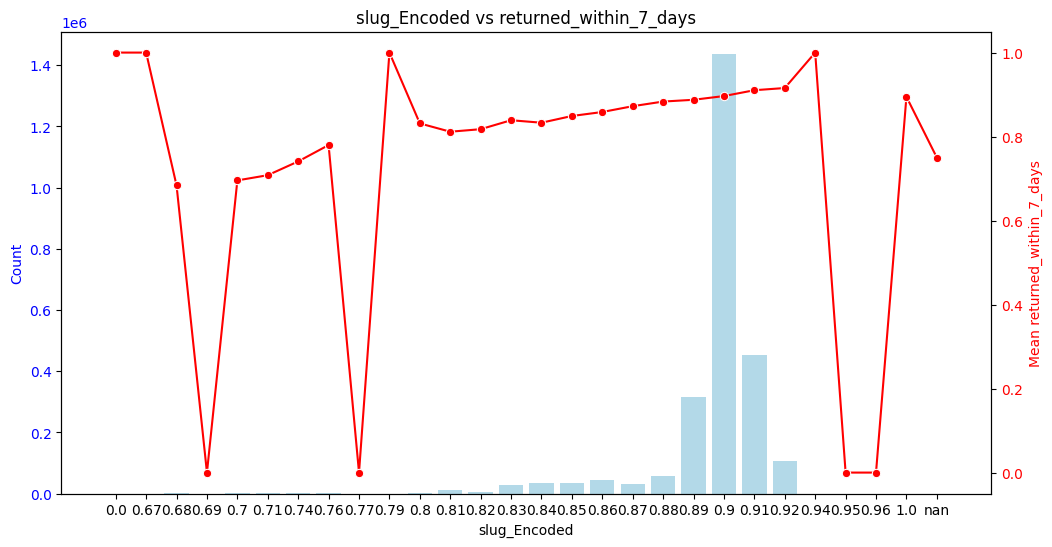

returned_within_7_days


In [115]:
def plot_features_with_target_before(df, target_col):
    for column in df.columns:
        print(column)
        if column == target_col or 'time' in column:
            continue
        
        # Categorical columns: Bar plot with mean target on secondary y-axis
        if df[column].nunique() < 10 or pd.api.types.is_categorical_dtype(df[column]) or pd.api.types.is_object_dtype(df[column]):
            plot_categorical_vs_target(df, column, target_col)
        
        # Numerical columns: Histogram with mean target as secondary y-axis
        else:
            plot_hist_vs_target(df, column, target_col, 5)

plot_features_with_target_before(df[['slug_Encoded', 'returned_within_7_days']], 'returned_within_7_days')

In [116]:
def leave_one_out_encoding(df, column, target):
    """
    Perform Leave-One-Out Encoding on a categorical column.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame.
    column (str): Column name to encode.
    target (str): Target column name.
    
    Returns:
    pd.Series: Encoded column values.
    """
    # Compute sum and count for each category
    category_sum = df.groupby(column)[target].transform('sum')
    category_count = df.groupby(column)[target].transform('count')
    
    # Compute LOO encoding value
    loo_encoding = np.round((category_sum - df[target]) / (category_count - 1), 2)
    
    return loo_encoding

In [117]:
df['slug_Encoded'] = leave_one_out_encoding(df, 'slug', 'returned_within_7_days').astype(str)

In [110]:
df['slug_Encoded']

0          0.896282
1          0.909654
2          0.896282
3          0.892733
4          0.836924
             ...   
2569687    0.896283
2569688    0.908312
2569689    0.899684
2569690    0.896282
2569691    0.896282
Name: slug_Encoded, Length: 2569692, dtype: float64

In [15]:
df_full = pl.read_parquet('/kaggle/input/csc2025-quang-feature-removed/quang.parquet')
df_full.shape

(2639235, 26)

In [33]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

def create_categorical_plot(df, cat_col, target_col):
    """
    Creates an interactive plot with bar chart of categorical column and line chart of target variable.
    """
    # [Previous implementation remains the same]
    data = df.groupby(cat_col, observed=False)[target_col].agg(['count', 'mean']).reset_index()
    data.sort_values(cat_col, inplace=True)
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    fig.add_trace(
        go.Bar(
            x=data[cat_col],
            y=data['count'],
            name="Count",
            marker_color='skyblue',
            opacity=0.7
        ),
        secondary_y=False,
    )
    
    fig.add_trace(
        go.Scatter(
            x=data[cat_col],
            y=data['mean'],
            name=f"Mean {target_col}",
            line=dict(color='red'),
            mode='lines+markers'
        ),
        secondary_y=True,
    )
    
    fig.update_layout(
        title=f'{cat_col} vs {target_col}',
        xaxis_title=cat_col,
        showlegend=True
    )
    
    fig.update_yaxes(title_text="Count", secondary_y=False, color='blue')
    fig.update_yaxes(title_text=f"Mean {target_col}", secondary_y=True, color='red')
    
    return fig

def create_numerical_plot(df, num_col, target_col, bins=10):
    """
    Creates an interactive histogram of numerical column with target variable as line chart.
    """
    # [Previous implementation remains the same]
    Q1 = df[num_col].quantile(0.25)
    Q3 = df[num_col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_filtered = df[(df[num_col] >= lower_bound) & (df[num_col] <= upper_bound)]
    df_filtered['bin'] = pd.cut(df_filtered[num_col], bins=bins)
    
    data = df_filtered.groupby('bin')[target_col].agg(['count', 'mean']).reset_index()
    data['bin'] = data['bin'].astype(str)
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    fig.add_trace(
        go.Bar(
            x=data['bin'],
            y=data['count'],
            name="Count",
            marker_color='skyblue',
            opacity=0.7
        ),
        secondary_y=False,
    )
    
    fig.add_trace(
        go.Scatter(
            x=data['bin'],
            y=data['mean'],
            name=f"Mean {target_col}",
            line=dict(color='red'),
            mode='lines+markers'
        ),
        secondary_y=True,
    )
    
    fig.update_layout(
        title=f'{num_col} Histogram vs {target_col} (Without Outliers)',
        xaxis_title=num_col,
        showlegend=True,
        xaxis_tickangle=45
    )
    
    fig.update_yaxes(title_text="Count", secondary_y=False, color='blue')
    fig.update_yaxes(title_text=f"Mean {target_col}", secondary_y=True, color='red')
    
    return fig

def create_interactive_dashboard(df, target_cols, output_file='dashboard.html'):
    """
    Creates an interactive dashboard with dropdown menus and saves it as an HTML file.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data
    target_cols (list): List of target columns to include in dropdown
    output_file (str): Name of the output HTML file
    
    Returns:
    str: Path to the generated HTML file
    """
    fig = go.Figure()
    feature_cols = [col for col in df.columns if col not in target_cols]
    feature_dropdown = []
    target_dropdown = []
    
    for feature in feature_cols:
        for target in target_cols:
            is_categorical = df[feature].nunique() == 2
            
            if is_categorical:
                new_fig = create_categorical_plot(df, feature, target)
            else:
                new_fig = create_numerical_plot(df, feature, target)
            
            for trace in new_fig.data:
                fig.add_trace(trace)
            
            feature_dropdown.append(
                dict(
                    args=[{"visible": [i == len(fig.data)-2 or i == len(fig.data)-1 
                                     for i in range(len(fig.data))]}],
                    label=feature,
                    method="update"
                )
            )
            
            target_dropdown.append(
                dict(
                    args=[{"visible": [i == len(fig.data)-2 or i == len(fig.data)-1 
                                     for i in range(len(fig.data))]}],
                    label=target,
                    method="update"
                )
            )
    
    fig.update_layout(
        title="Interactive Data Analysis Dashboard",
        updatemenus=[
            dict(
                buttons=feature_dropdown,
                direction="down",
                showactive=True,
                x=0.1,
                xanchor="left",
                y=1.1,
                yanchor="top",
                name="Feature"
            ),
            dict(
                buttons=target_dropdown,
                direction="down",
                showactive=True,
                x=0.4,
                xanchor="left",
                y=1.1,
                yanchor="top",
                name="Target"
            )
        ],
        annotations=[
            dict(text="Feature:", x=0, y=1.1, yref="paper", xref="paper", showarrow=False),
            dict(text="Target:", x=0.3, y=1.1, yref="paper", xref="paper", showarrow=False)
        ]
    )
    
    # Show only first feature-target combination initially
    fig.data[0].visible = True
    fig.data[1].visible = True
    for i in range(2, len(fig.data)):
        fig.data[i].visible = False
    
    # Save as HTML file
    fig.write_html(output_file)
    return output_file

In [34]:
df.head()

,feature1,feature2,target1,target2
0,-0.099522,A,6.360626,0.645032
1,-0.150789,A,2.093912,1.466244
2,2.014868,A,5.436262,8.690695
3,-2.135780,B,5.242656,6.601731
4,1.717128,B,4.612740,3.475231


In [45]:
fig = create_interactive_dashboard(df.iloc[:, 2:], ['returned_within_7_days_max', 'session_seconds_mean'])

<ipython-input-33-e5cb93799fa5>:61: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-33-e5cb93799fa5>:63: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-33-e5cb93799fa5>:61: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-33-e5cb93799fa5>:63: FutureWarning:

The default of observe

In [42]:
fig

'dashboard.html'